# 1. Классический скоринг

In [ ]:
!pip install autowoe -q
!pip install lightgbm==3.3.5  -q
!pip install catboost -q
!pip install pandas==1.5.2  -q
!pip install shap==0.34.0  -q
!pip install crosspredict==1.1.9 --no-deps  -q

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import yaml
import warnings
from autowoe import AutoWoE, ReportDeco
from collections import defaultdict
from crosspredict.report_binary import ReportBinary
from crosspredict.nodes import model_fit, forward_selection, hyperopt_fit, onefactor, model_single_fit
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!wget https://raw.githubusercontent.com/senior-sigan/Tinkoff-Data-Science-Challenge/master/task1/data/credit_train.csv.zip

--2024-03-14 06:02:14--  https://raw.githubusercontent.com/senior-sigan/Tinkoff-Data-Science-Challenge/master/task1/data/credit_train.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3276871 (3.1M) [application/zip]
Saving to: ‘credit_train.csv.zip’

credit_train.csv.zi 100%[===================>]   3.12M  --.-KB/s    in 0.04s   

2024-03-14 06:02:14 (74.5 MB/s) - ‘credit_train.csv.zip’ saved [3276871/3276871]



In [ ]:
df = pd.read_csv('credit_train.csv.zip', encoding='cp1251', delimiter=';', index_col='client_id')
import datetime
X = pd.date_range(datetime.date(2022,1,1),datetime.date(2023,1,1)).tolist()*int(170746/366)+pd.date_range(datetime.date(2022,1,1),datetime.date(2023,1,1),190).tolist()
X = [x.date() for x in X]
df['SIGN_DATE'] = X
df['SIGN_DATE_mon'] = df['SIGN_DATE'].map(lambda x: x.replace(day=1))
df['credit_sum'] = df['credit_sum'].str.replace(',','.')
df['credit_sum'] = pd.to_numeric(df['credit_sum'])
df['score_shk'] = df['score_shk'].str.replace(',','.')
df['score_shk'] = pd.to_numeric(df['score_shk'])

In [ ]:
params = '''
lgb_params:
  bagging_fraction: 0.849285747554019
  bagging_freq: 5
  bagging_seed: 0
  boosting_type: 'gbdt'
  data_random_seed: 0
  drop_seed: 0
  feature_fraction: 0.8212766928844304
  feature_fraction_seed: 0
  lambda_l1: 0.8955546599539566
  lambda_l2: 1.4423261095989717
  learning_rate: 0.03
  max_bin: 255
  max_depth': 43
  metric: 'auc'
  min_data_in_leaf: 149
  min_sum_hessian_in_leaf: 1.804477623298885
  num_leaves: 363
  objective: 'binary'
  seed: 0
  verbose: -1
n_repeats: 2
n_splits: 5
num_boost: 9999
early_stopping: 50
col_target: 'open_account_flg'
col_client: 'id_client'
cv_byclient: False
cols_exclude: ['predict_stacking','predict_boosting','SIGN_DATE_mon','SIGN_DATE','open_account_flg','target_adversarial','predict']
cols_cat: ['tariff_id', 'gender','marital_status','job_position','living_region','education']

adversarial_frac: 0.25
col_date: 'SIGN_DATE'
col_date_mon: 'SIGN_DATE_mon'
col_adversarial: 'target_adversarial'

hyperopt_trials: 3
'''
with open('params.yaml','w') as f:
    f.write(params)

In [ ]:
with open('params.yaml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

### Autowoe

In [ ]:
cat_feature_list = params['cols_cat']
num_feature_list = list(set(df.columns)-set(params['cols_cat'])-set([params['col_target']]))

In [ ]:

auto_woe = AutoWoE(
    interpreted_model=True,
    monotonic=True,
    max_bin_count=10,
    select_type=50,
    pearson_th=0.9,
    auc_th=.505,
    vif_th=10.,
    imp_th=0,
    th_const=32,
    force_single_split=True,
    th_nan=0.01,
    th_cat=0.005,
    woe_diff_th=0.01,
    min_bin_size=0.01,
    min_bin_mults=(2, 4),
    min_gains_to_split=(0.0, 0.5, 1.0),
    auc_tol=1e-3,
    cat_alpha=100,
    cat_merge_to="to_woe_0",
    nan_merge_to="to_woe_0",
    oof_woe=True,
    n_folds=5,
    n_jobs=8,
    l1_grid_size=20,
    l1_exp_scale=6,
    imp_type="feature_imp",
    regularized_refit=True,
    p_val=0.05,
    debug=False,
    verbose=0
)

auto_woe = ReportDeco(auto_woe)
cat_feature_type = {x: 'cat' for x in cat_feature_list }
num_feature_type = {x: 'real' for x in num_feature_list}
feature_list = num_feature_list + cat_feature_list

features_type = dict(**num_feature_type, **cat_feature_type)

auto_woe.fit(
    df[feature_list + [params['col_target']]].sample(n=10000),
    target_name=params['col_target'],
    features_type=features_type,
    group_kf=None,
)

df['predict'] = auto_woe.predict_proba(df)



[LightGBM] [Info] Number of positive: 1377, number of negative: 6623
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172125 -> initscore=-1.570641
[LightGBM] [Info] Start training from score -1.570641


In [ ]:
print(auto_woe.get_sql_inference_query('name_table'))


SELECT
  1 / (1 + EXP(-(
    -1.559
    -1.232*WOE_TAB.tariff_id
    -0.599*WOE_TAB.credit_sum
    -1.318*WOE_TAB.credit_month
    -0.756*WOE_TAB.living_region
    -0.498*WOE_TAB.age
    -0.434*WOE_TAB.credit_count
    -0.517*WOE_TAB.education
    -0.411*WOE_TAB.overdue_credit_count
    -0.517*WOE_TAB.marital_status
    -0.291*WOE_TAB.monthly_income
    -0.77*WOE_TAB.score_shk
    -0.719*WOE_TAB.job_position
    -0.844*WOE_TAB.gender
  ))) as PROB,
  WOE_TAB.*
FROM 
    (SELECT
    CASE
      WHEN (tariff_id IS NULL OR LOWER(CAST(tariff_id AS VARCHAR(50))) = 'nan') THEN 0
      WHEN tariff_id IN (1.0, 1.16) THEN 0.682
      WHEN tariff_id == 1.1 THEN -0.13
      WHEN tariff_id == 1.3 THEN -0.604
      WHEN tariff_id == 1.32 THEN -1.031
      WHEN tariff_id IN (1.4, 1.5) THEN 0.808
      WHEN tariff_id == 1.9 THEN 1.382
      ELSE 0.287
    END AS tariff_id,
    CASE
      WHEN (credit_sum IS NULL OR credit_sum = 'NaN') THEN 0
      WHEN credit_sum <= 7473.5 THEN -0.814
      WHEN credi

In [ ]:
report_params = {"automl_date_column": params['col_date_mon'],
                 "output_path": "report/",
                 "report_name": "white box",
                 "report_version_id": 1,
                 "city": "Moscow",
                 "model_aim": "application default",
                 "model_name": "application default",
                 "zakazchik": "-",
                 "high_level_department": "DS",
                 "ds_name": "-",
                 "target_descr": "default",
                 "non_target_descr": "not default"}

auto_woe.generate_report(report_params)

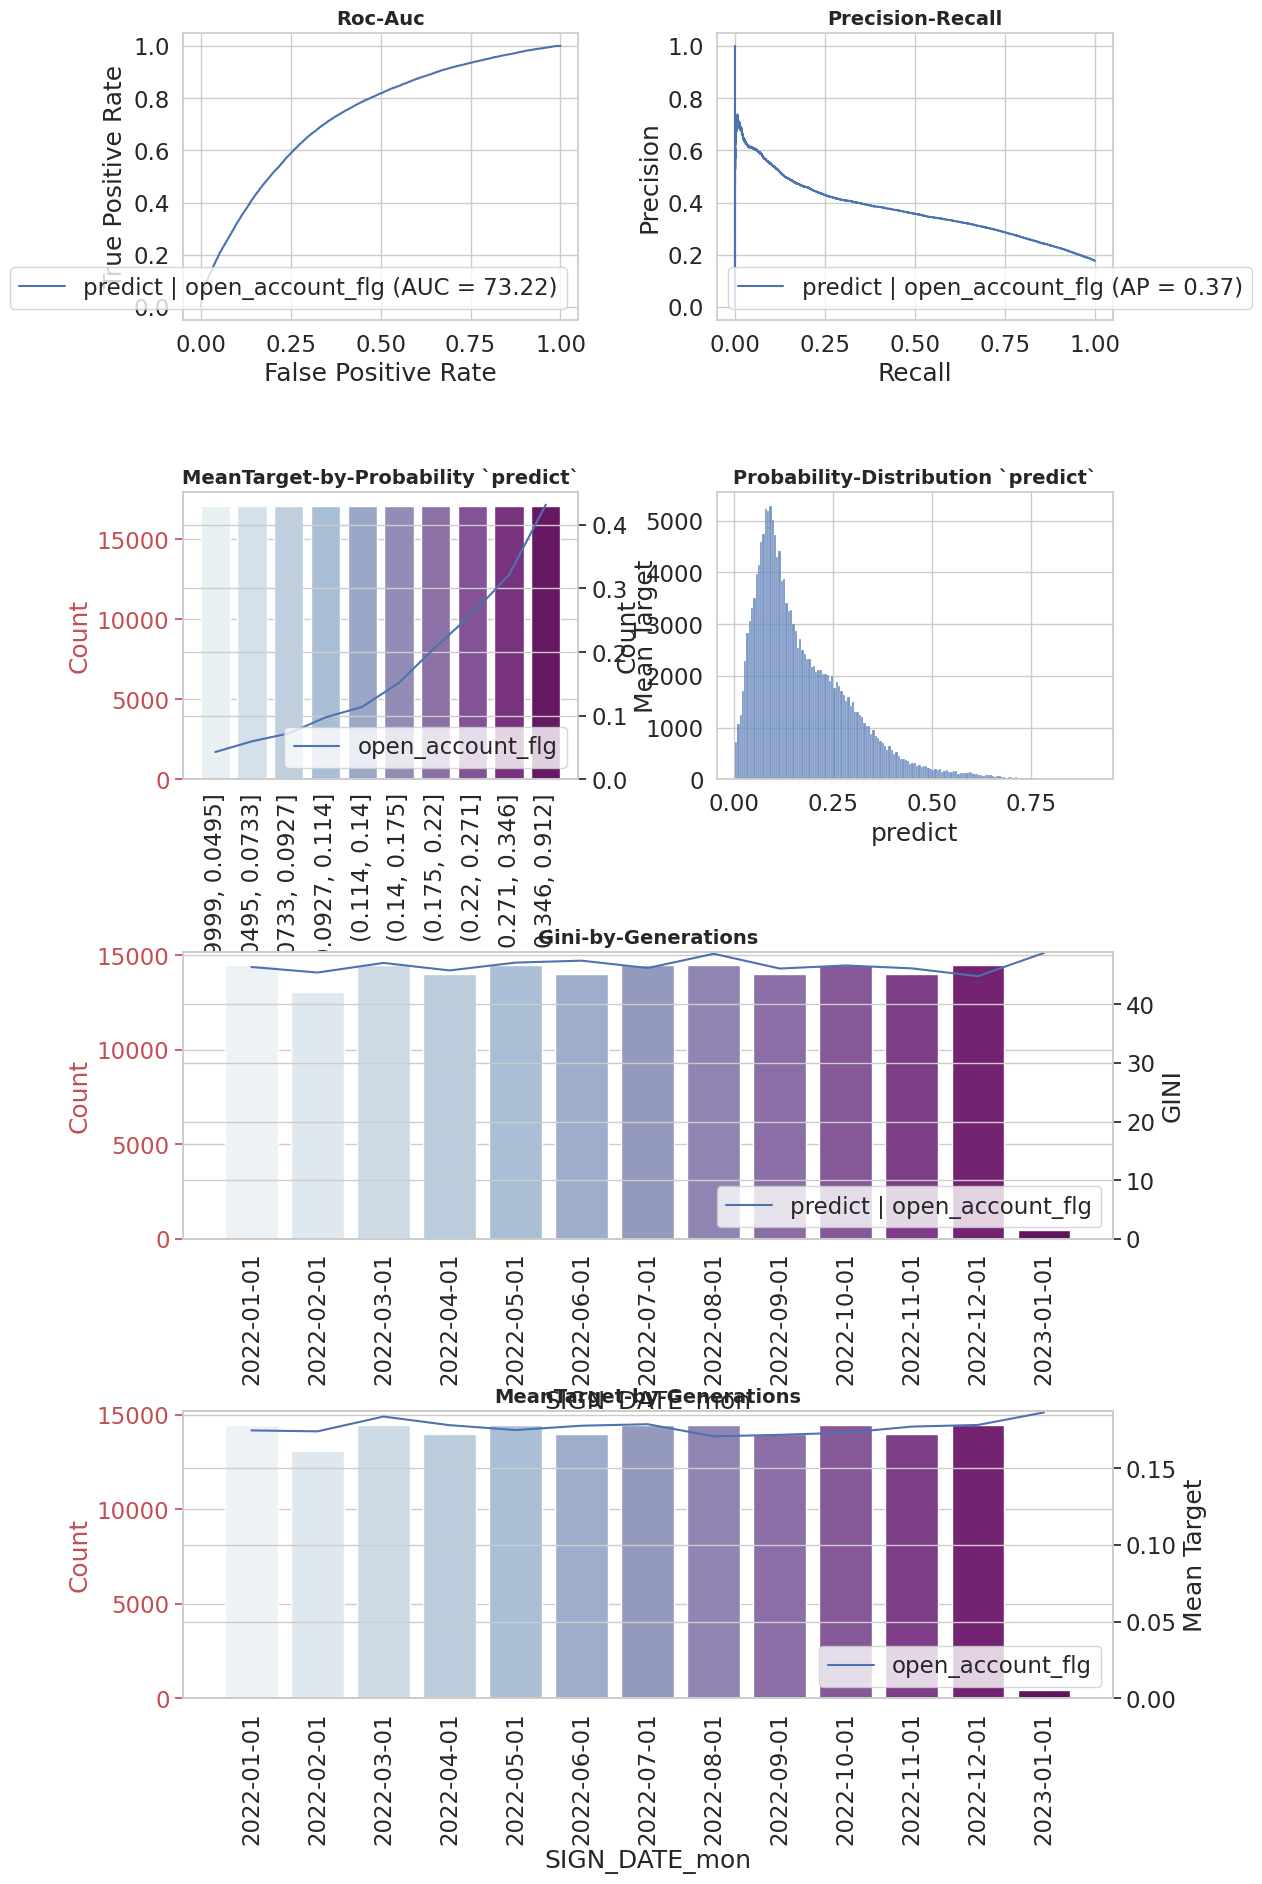

In [ ]:
a = ReportBinary()
a.plot_report(
    df,
    report_shape = (5,2),
    report={'Roc-Auc':  {'loc':(0, 0)},
          'Precision-Recall': [{'loc':(0, 1)}],
          'MeanTarget-by-Probability': [{'loc':(1, 0)}],
          'Gini-by-Generations': {'loc':(2,0), 'colspan':2},
          'MeanTarget-by-Generations': {'loc':(3,0), 'colspan':2},
          'Probability-Distribution': [{'loc':(1,1)}]
            },
    cols_score = ['predict'],
    cols_target = [params['col_target']],
    col_generation_deals=params['col_date_mon']
)
# a.fig.savefig('report1.png')

### Boosting

In [ ]:
def categorizer(df, col):
  X = df[col].value_counts()
  X = X[X>100]
  mapping = {j:i+2 for i,j in enumerate(X.index)}

  d = defaultdict(lambda: 1)
  d.update(mapping)
  return d

In [ ]:
mapping = {}

for col in params['cols_cat']:
  mapping1 = categorizer(df, col)
  df[col] = df[col].map(mapping1)
  mapping.update({col:mapping1})

In [ ]:
test = df[df[params['col_date']]>=datetime.date(2022,8,1)].copy()
train = df[df[params['col_date']]<datetime.date(2022,8,1)].copy()

#### Adversarial

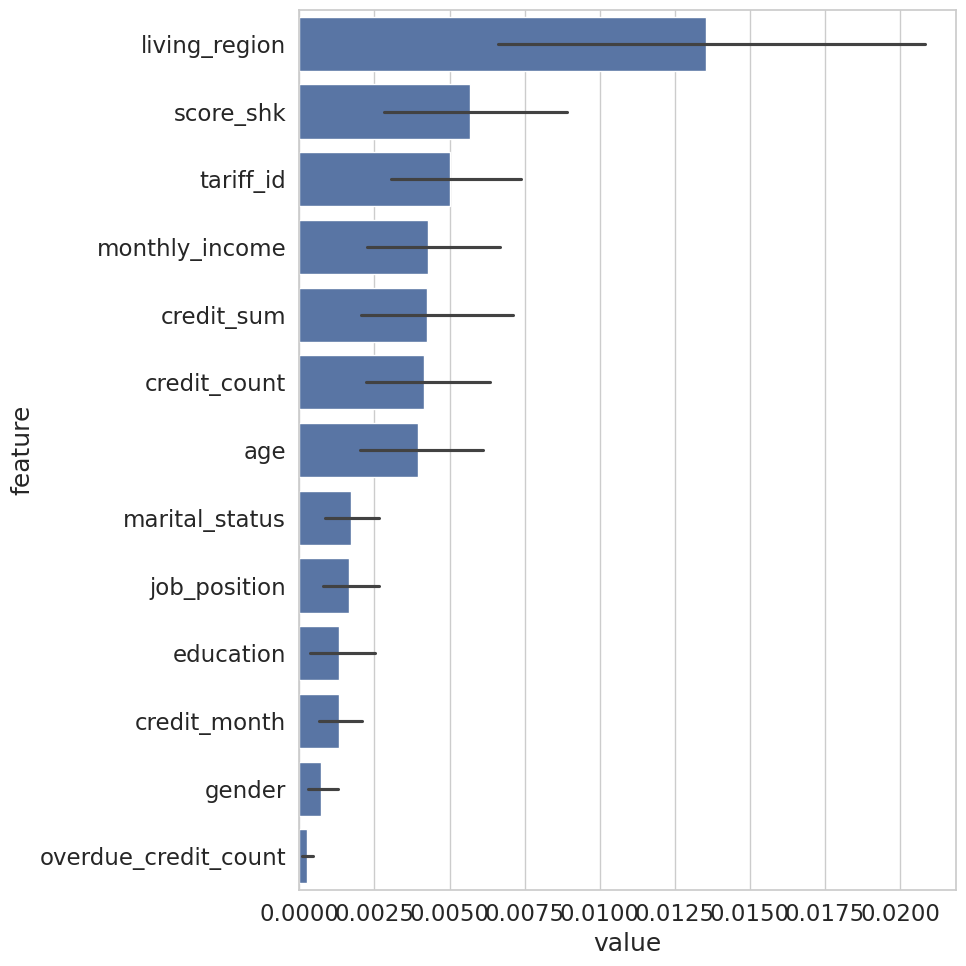

In [ ]:
def adversarial_make_target(train, adversarial_frac, col_adversarial, col_date, **kwargs):
    target_ind = train.sort_values(col_date)[-int(train.shape[0] * adversarial_frac):].index
    train[col_adversarial] = train.index.isin(target_ind).astype(int)
    return train
df = adversarial_make_target(df, **params)
params_adversarial = dict(params)
params_adversarial.update({'col_target':params['col_adversarial']})
params_adversarial['cols_exclude'].append('id_contract')
fig, shap_df, report, model_class = model_fit(df, **params_adversarial)

In [ ]:
print(report)

{
    "col_target": "target_adversarial",
    "feature_len": "13",
    "frac": [
        "0.50212",
        "0.50295",
        "0.50138",
        "0.50248",
        "0.50403",
        "0.50667",
        "0.50762",
        "0.50454",
        "0.50706",
        "0.50302"
    ],
    "loss": "-0.50241",
    "num_boost": "0",
    "score_max": "0.50241",
    "scores_all": [
        "0.50212",
        "0.50295",
        "0.50138",
        "0.50248",
        "0.50403",
        "0.50667",
        "0.50762",
        "0.50454",
        "0.50706",
        "0.50302"
    ],
    "shap_df": "|    | feature              |        mean |        std |\n|---:|:---------------------|------------:|-----------:|\n|  0 | living_region        | 0.0135495   | 0.0121441  |\n|  1 | score_shk            | 0.00569032  | 0.00511177 |\n|  2 | tariff_id            | 0.00501995  | 0.00391228 |\n|  3 | monthly_income       | 0.00428099  | 0.00377111 |\n|  4 | credit_sum           | 0.00425896  | 0.00420052 |\n|  5 | cred

#### One factor analysis - unstable

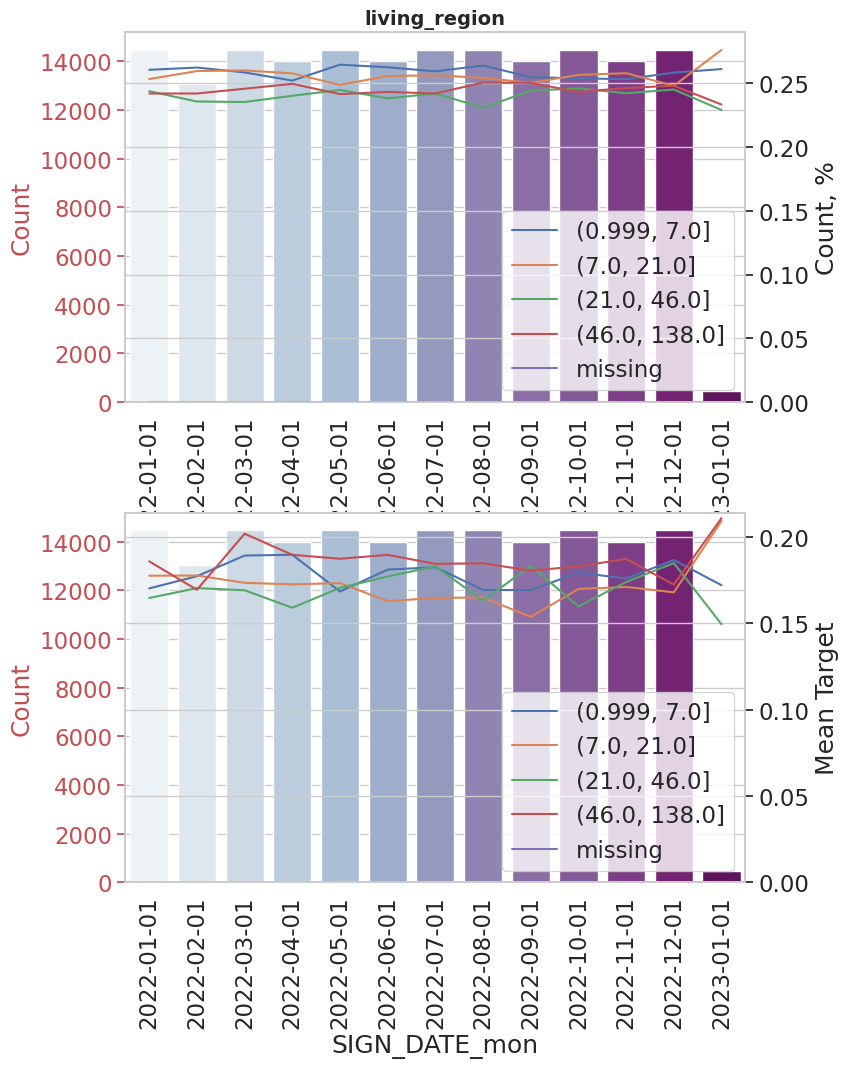

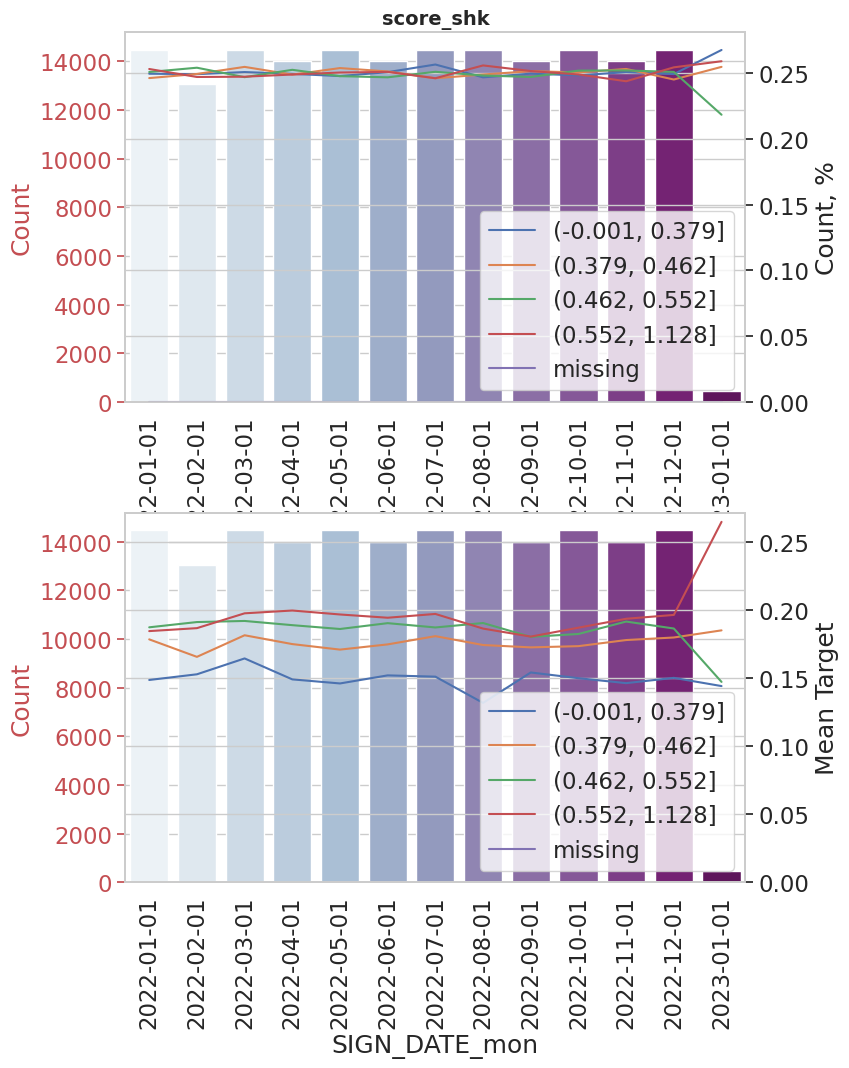

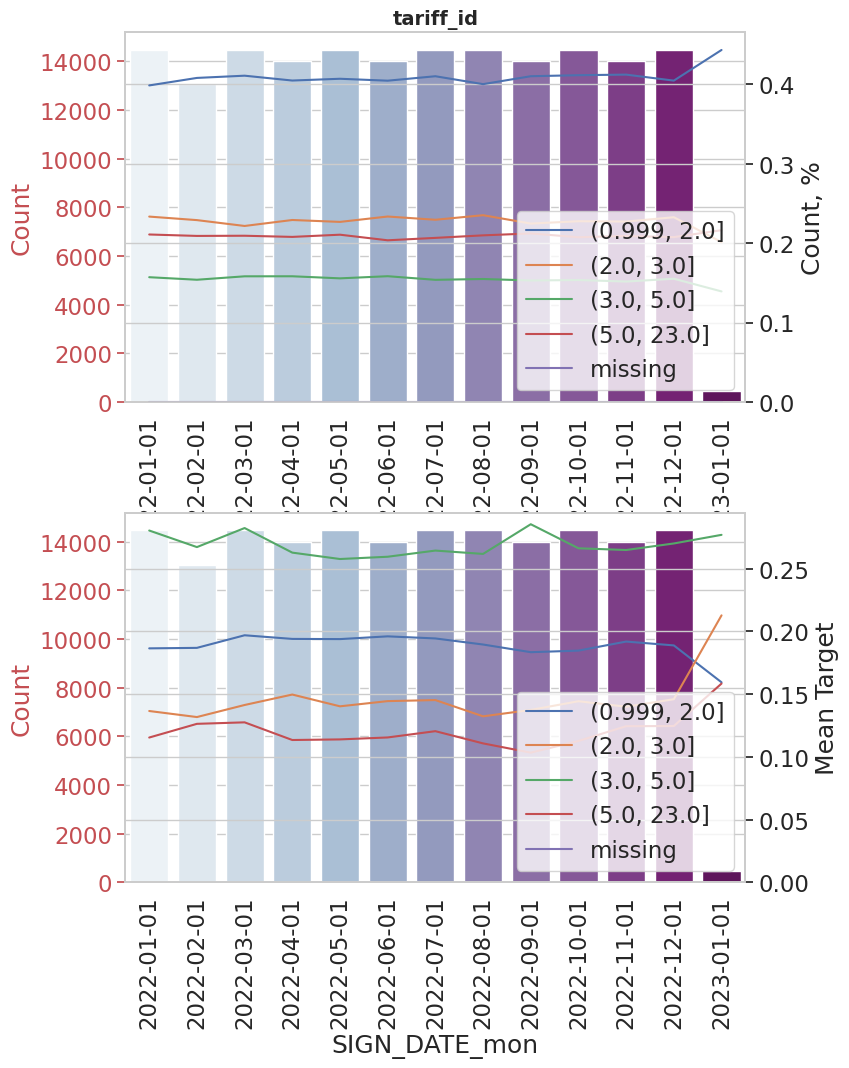

In [ ]:
report_onefactor = onefactor(df, shap_df, col_date=params['col_date_mon'],
          col_target=params['col_target'],
          report_directory='report',
        output_file='README_onefactor_unstable.md',
          top_features=3)

#### Model fit on all data

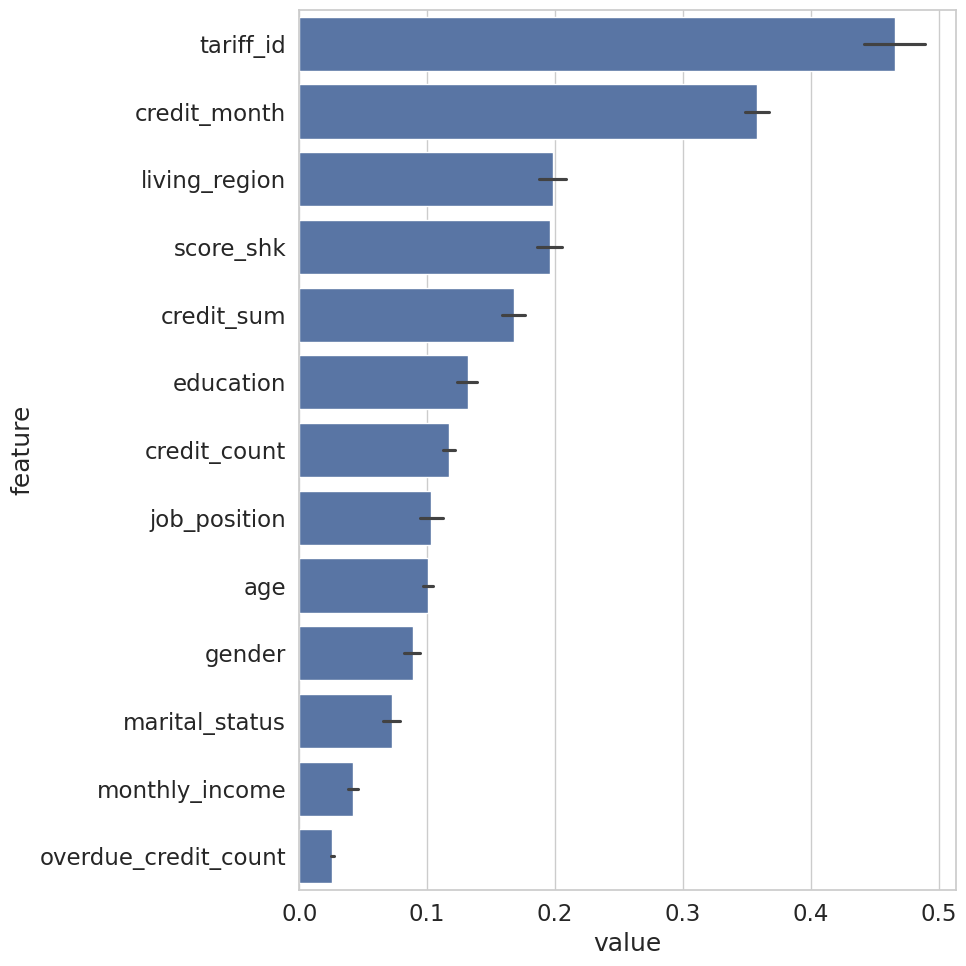

In [ ]:
fig, shap_df, report, model_class = model_fit(train, **params)

In [ ]:
shap_df

feature      mean       std
0              tariff_id  0.465732  0.043345
1           credit_month  0.357756  0.015321
2          living_region  0.198206  0.018609
3              score_shk  0.195819  0.017410
4             credit_sum  0.168002  0.015144
5              education  0.131649  0.013336
6           credit_count  0.116849  0.007423
7           job_position  0.103314  0.015161
8                    age  0.100832  0.006523
9                 gender  0.088539  0.010419
10        marital_status  0.072311  0.011566
11        monthly_income  0.042082  0.006655
12  overdue_credit_count  0.025899  0.002031

#### Forward selection

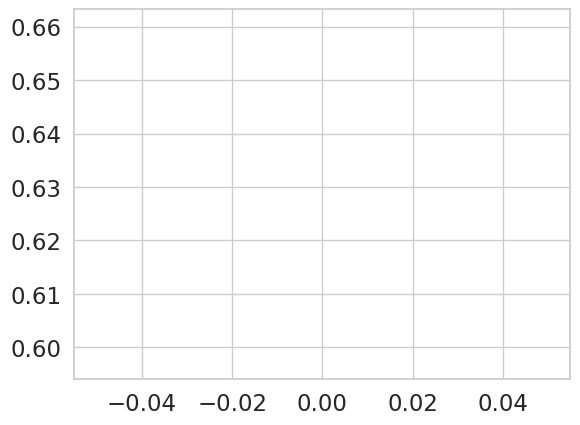

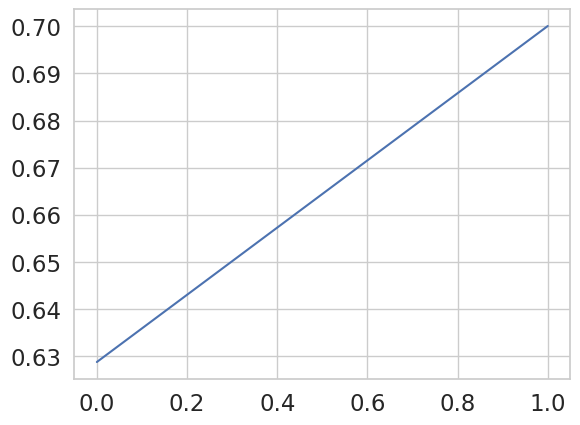

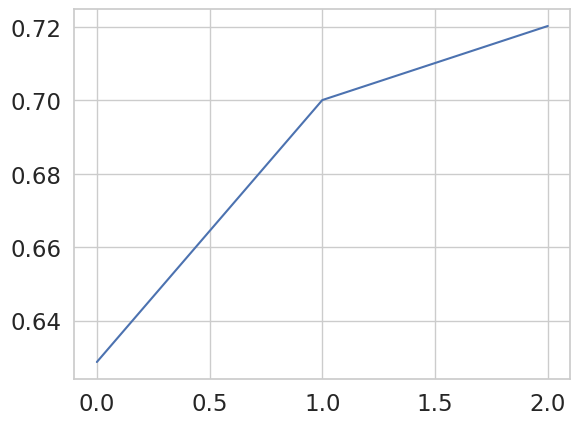

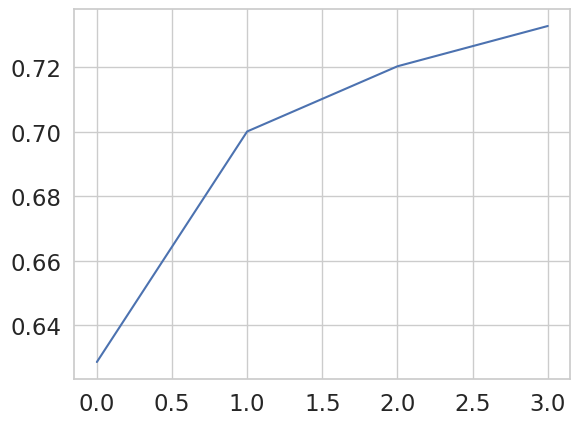

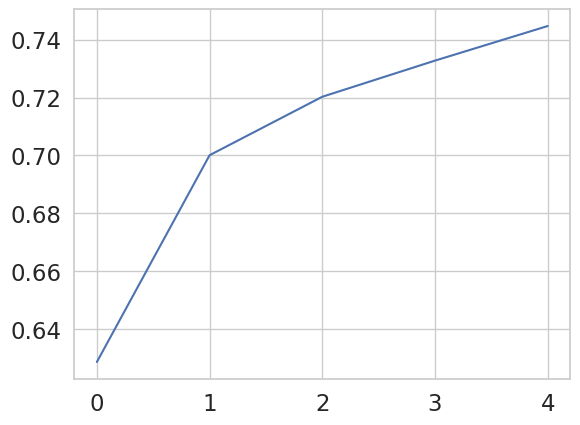

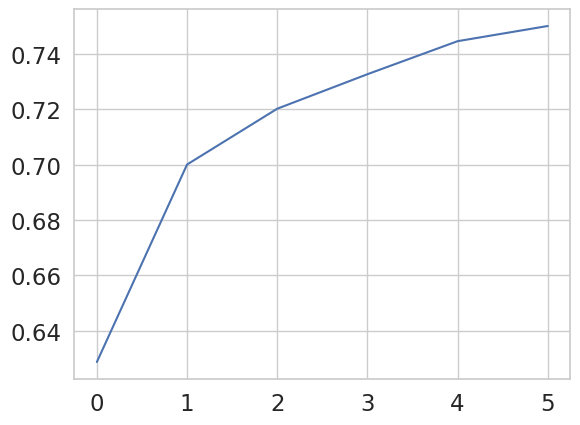

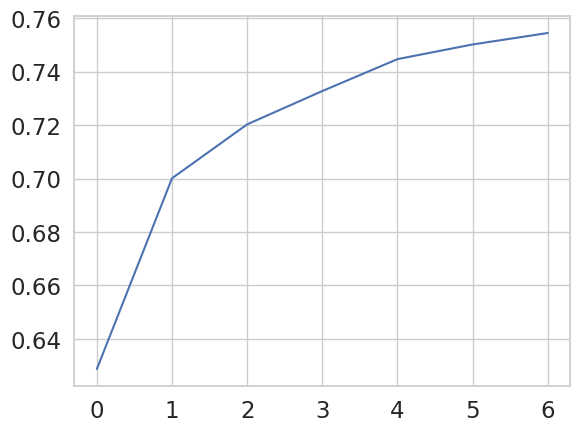

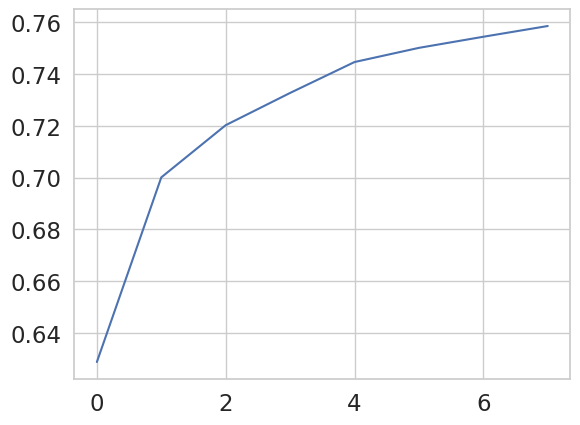

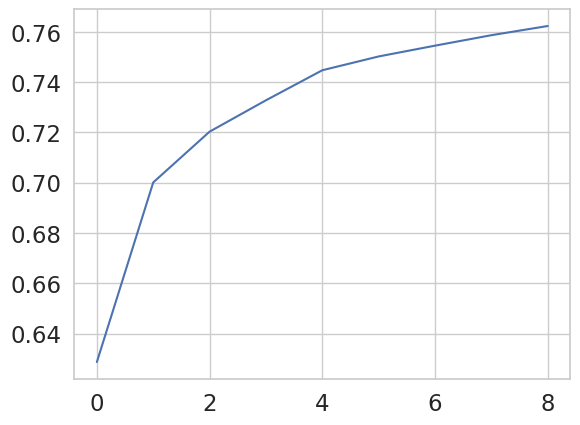

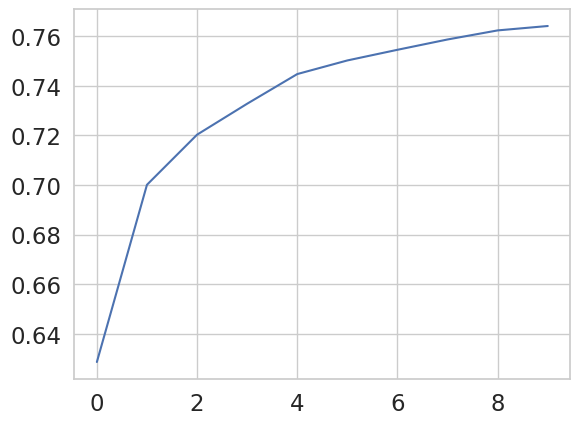

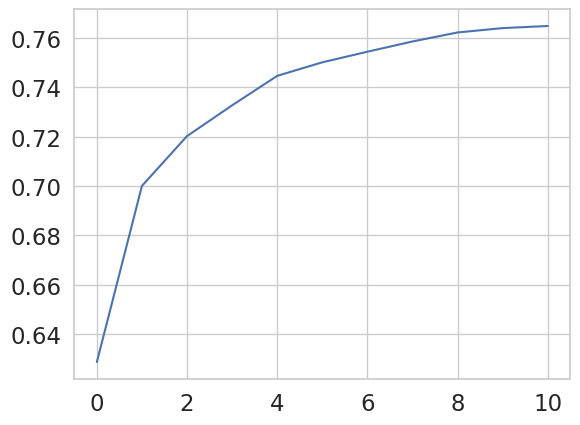

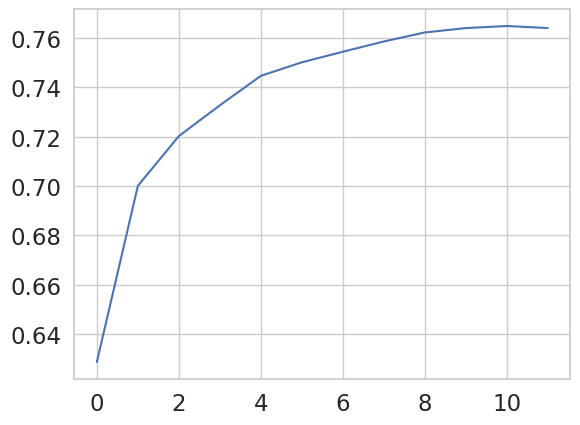

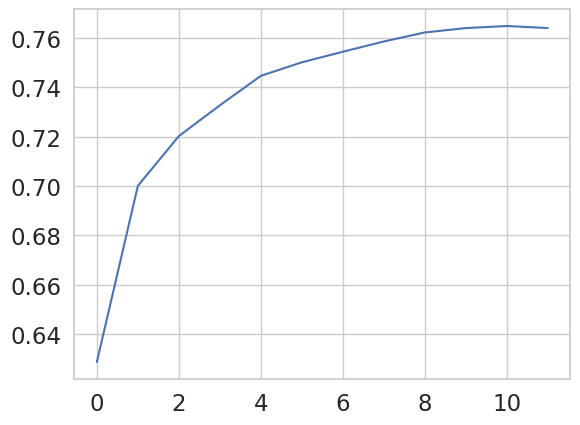

In [ ]:
params_fs = dict(params)
params_fs['feature_name'] = shap_df['feature'].values.tolist()
scores_df, top_features = forward_selection(train, **params_fs)

In [ ]:
import json
top_features = int(json.loads(top_features)['feature_selection'])

#### Hyperopt

In [ ]:
params_hp = dict(params_fs)
params_hp['feature_name']=scores_df['index'][:top_features].values.tolist()

In [ ]:
results = hyperopt_fit(train, **params_hp)

100%|██████████| 3/3 [10:35<00:00, 211.95s/trial, best loss: -0.7633003536865438]


In [ ]:
print(results)


{
    "hyperopt_trials": 3,
    "params": {
        "bagging_fraction": 0.8261936404095582,
        "bagging_freq": 5,
        "bagging_seed": 0,
        "boosting_type": "gbdt",
        "data_random_seed": 0,
        "drop_seed": 0,
        "feature_fraction": 0.774105695356128,
        "feature_fraction_seed": 0,
        "lambda_l1": 1.6820775100980971,
        "lambda_l2": 0.5039234289699986,
        "learning_rate": 0.03,
        "max_bin": 255,
        "max_depth": 47,
        "metric": "auc",
        "min_data_in_leaf": 71,
        "min_sum_hessian_in_leaf": 2.2531244982631957,
        "num_leaves": 259,
        "objective": "binary",
        "seed": 0,
        "verbose": -1
    }
}


#### Fit final model

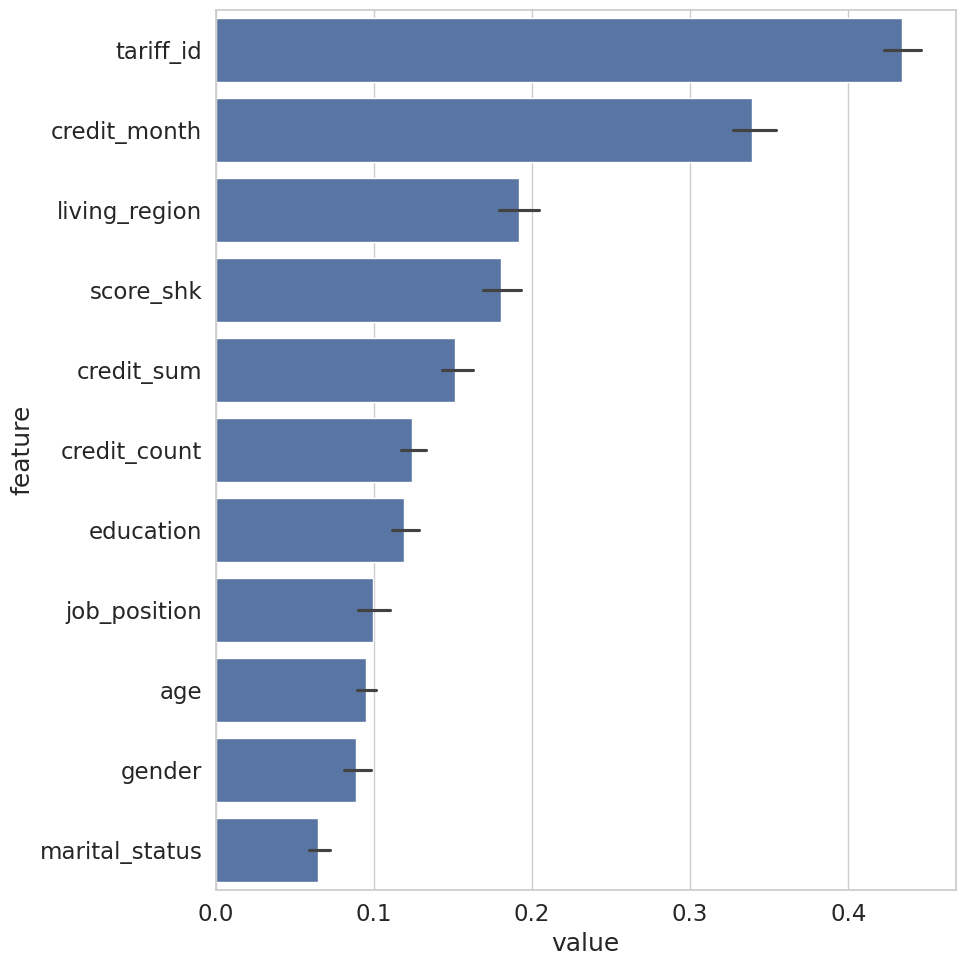

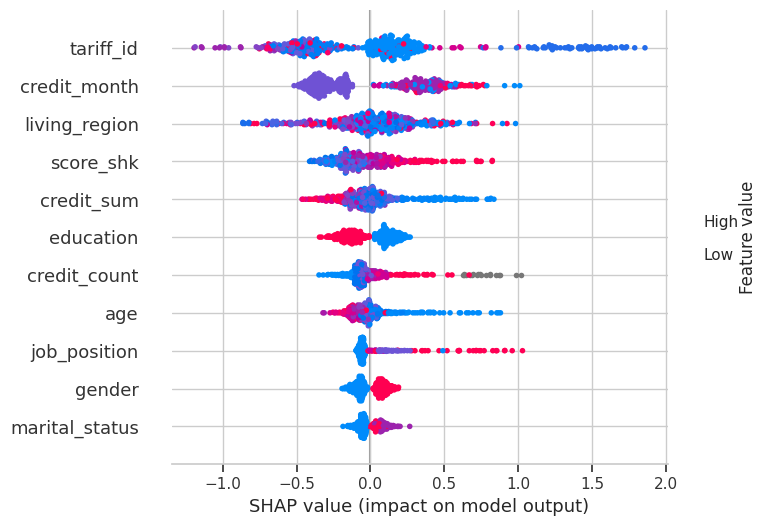

In [ ]:
params_hp['lgb_params'] = json.loads(results)['params']
fig, shap_df, report, model_class = model_fit(train, **params_hp)
fig = model_class.shap_summary_plot(train)
model_class.scores
model_class.num_boost_optimal
params_hp['num_boost'] = model_class.num_boost_optimal
params_hp['early_stopping'] = None
params_hp['cols_cat']=None
model_str, model = model_single_fit(train, **params_hp)

#### One factor analysis - features

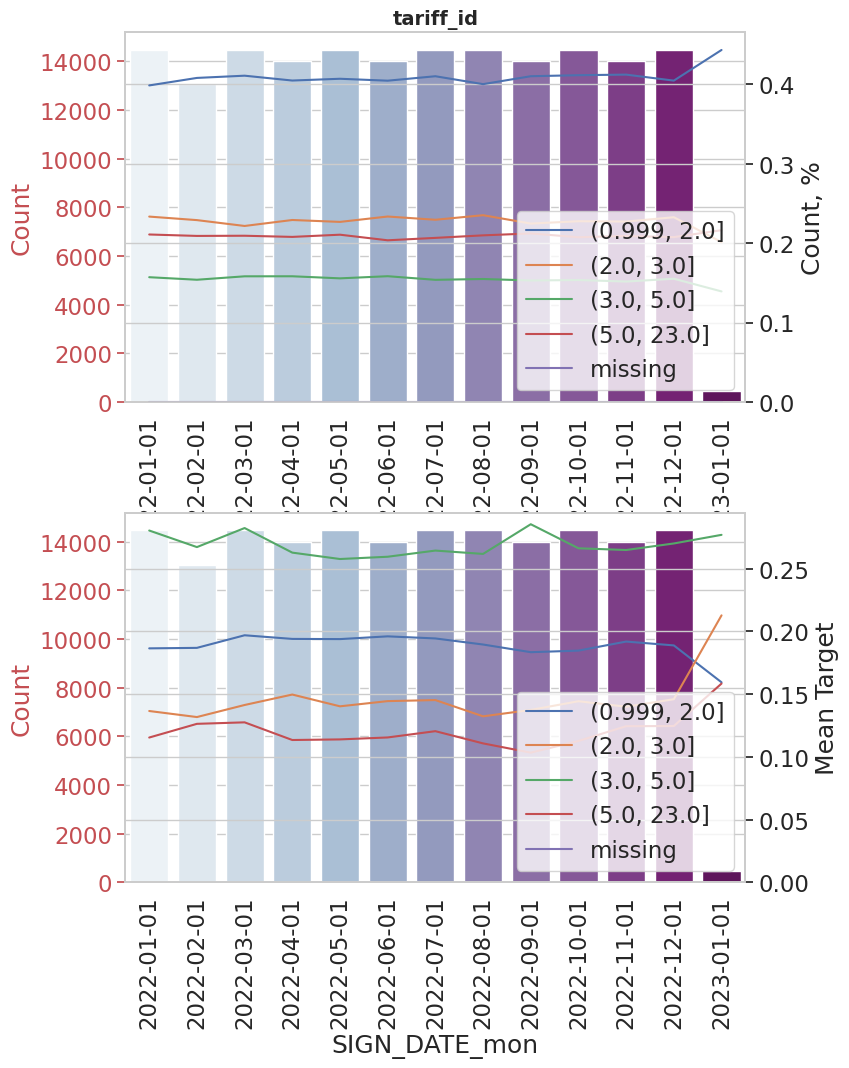

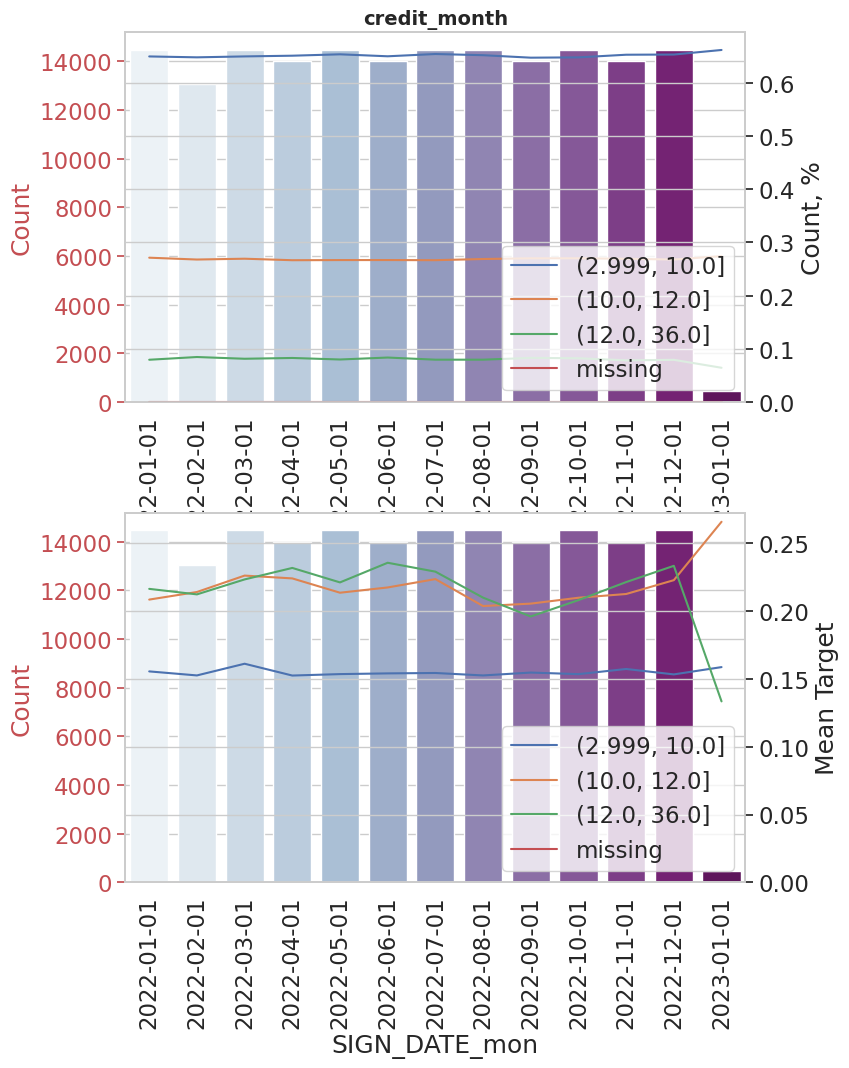

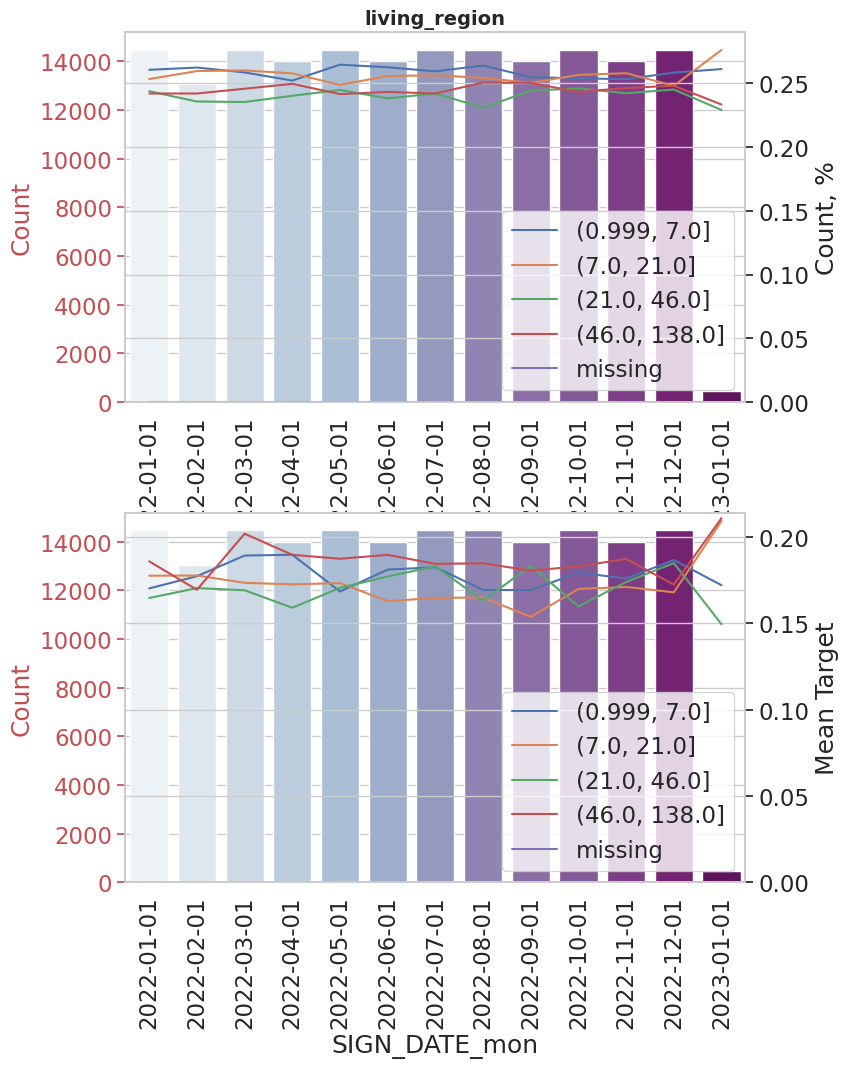

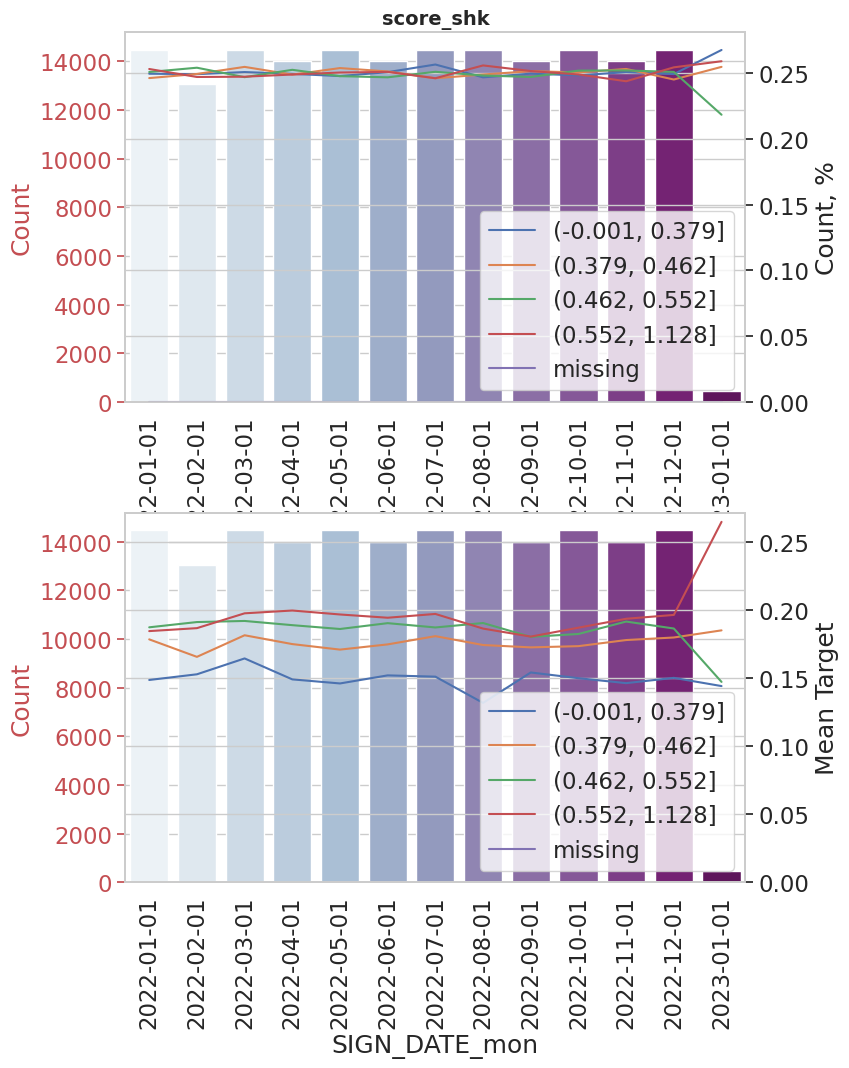

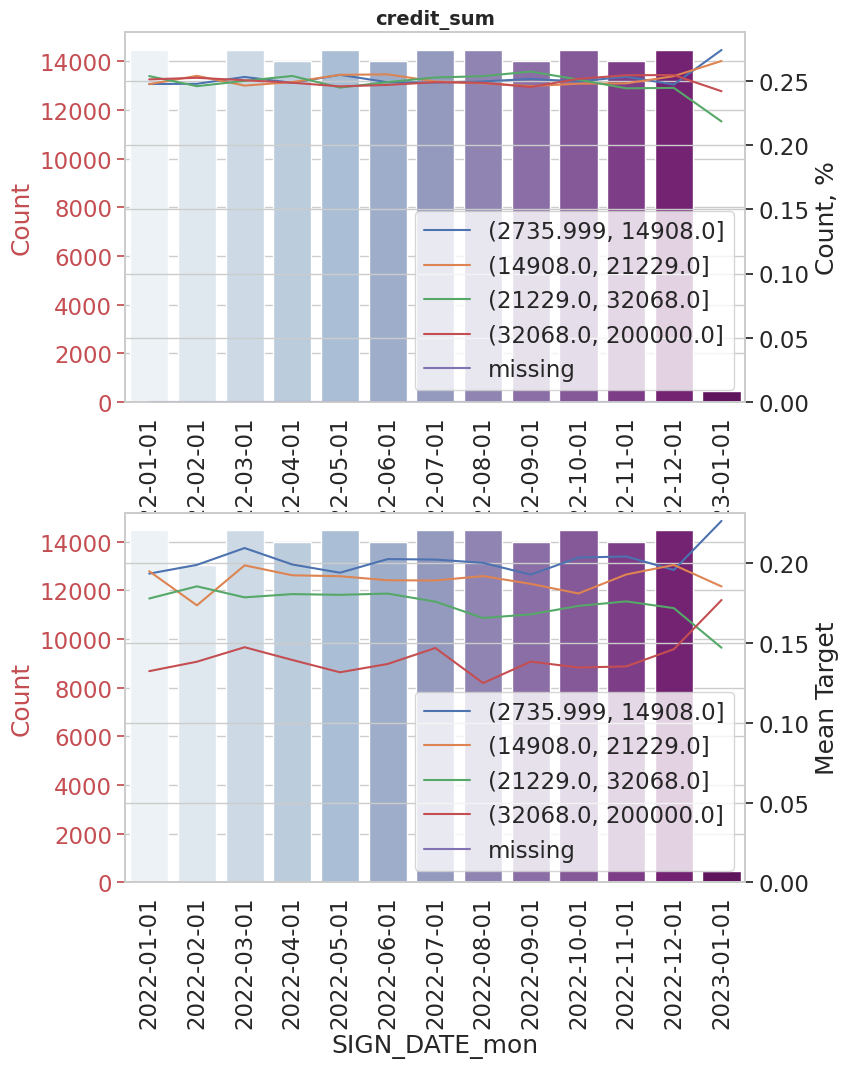

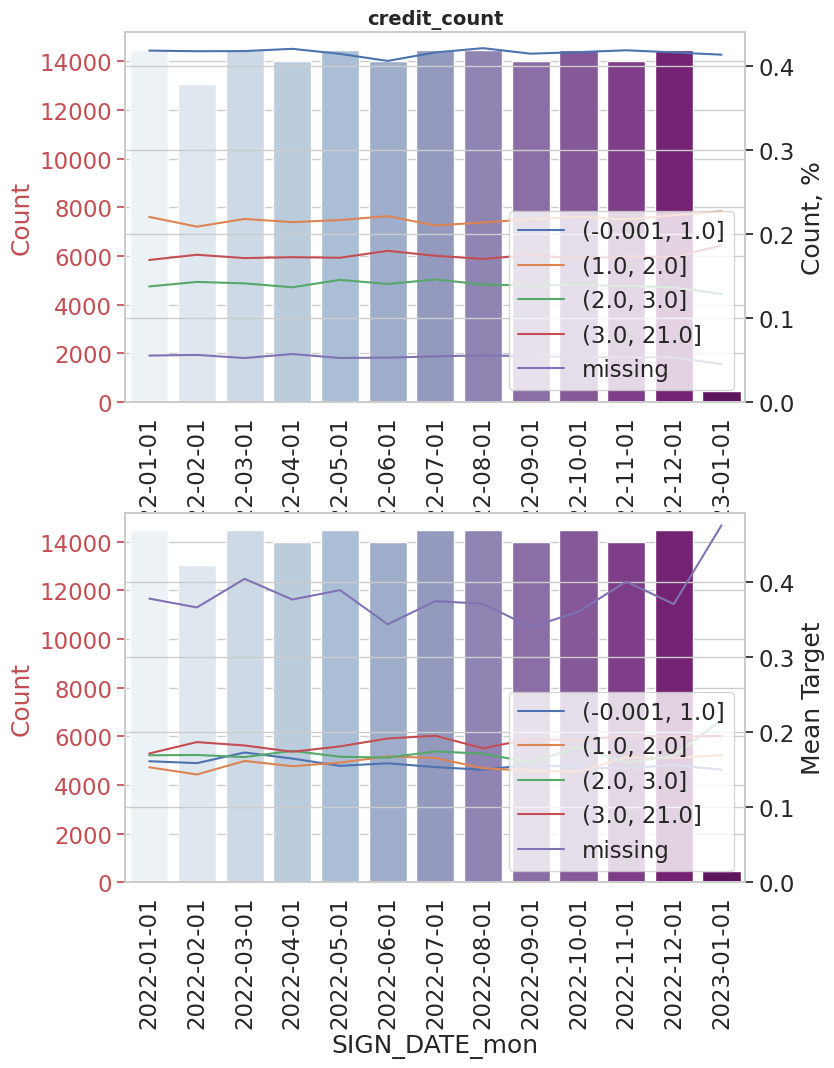

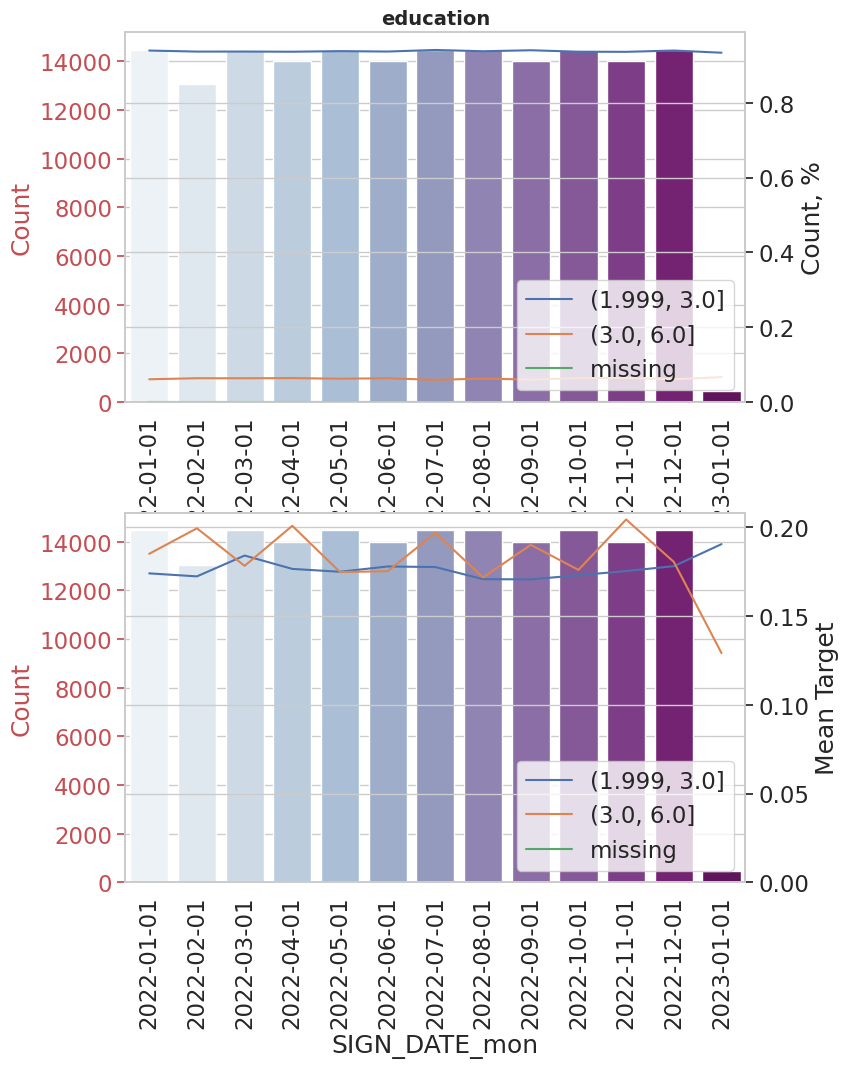

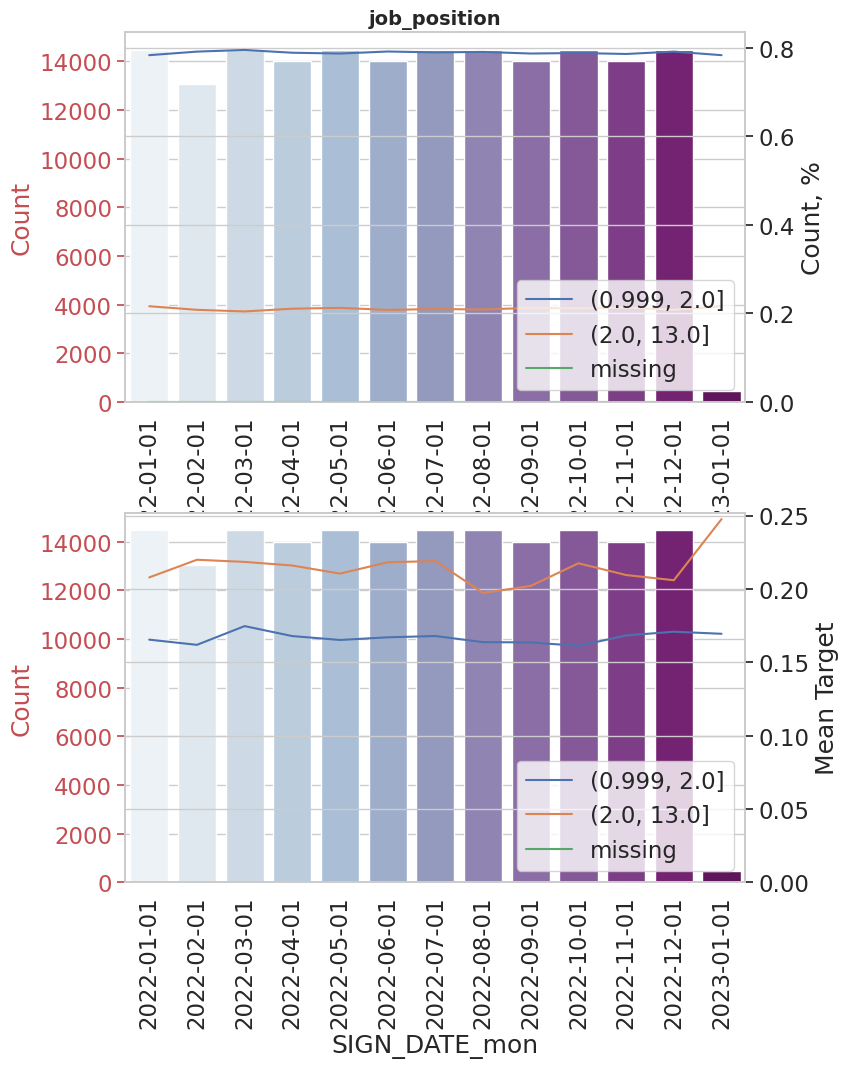

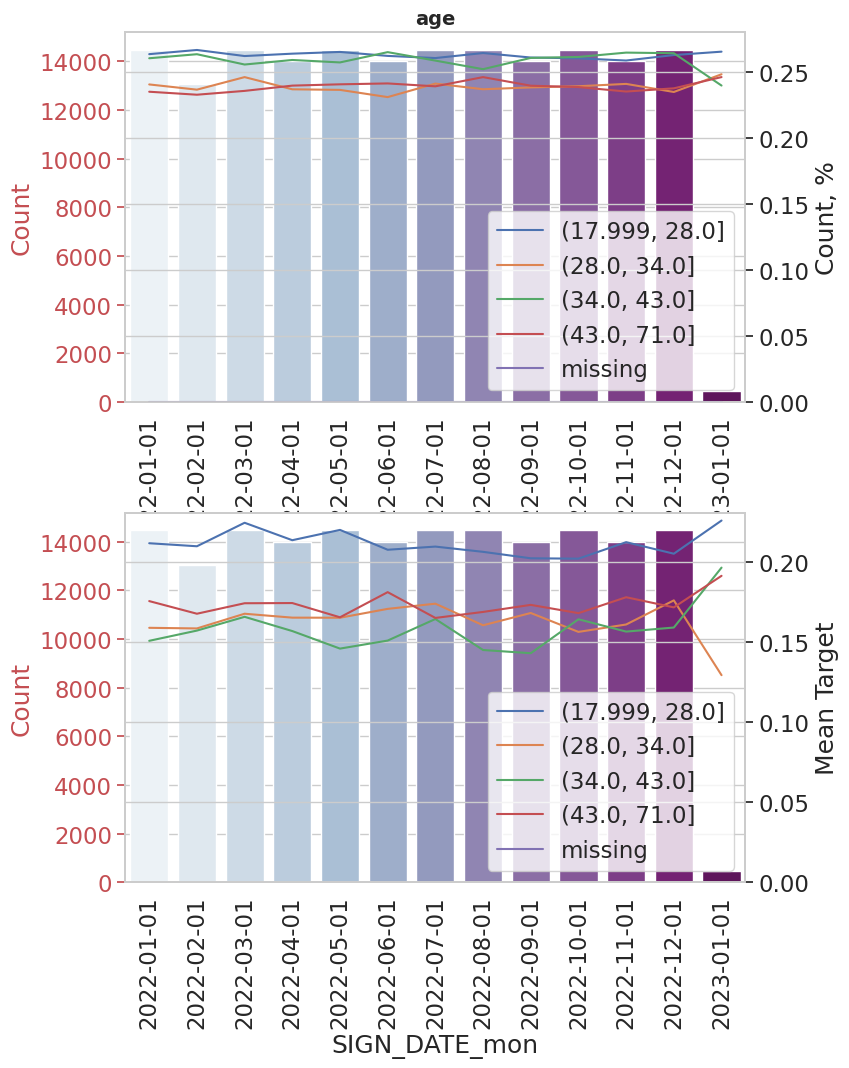

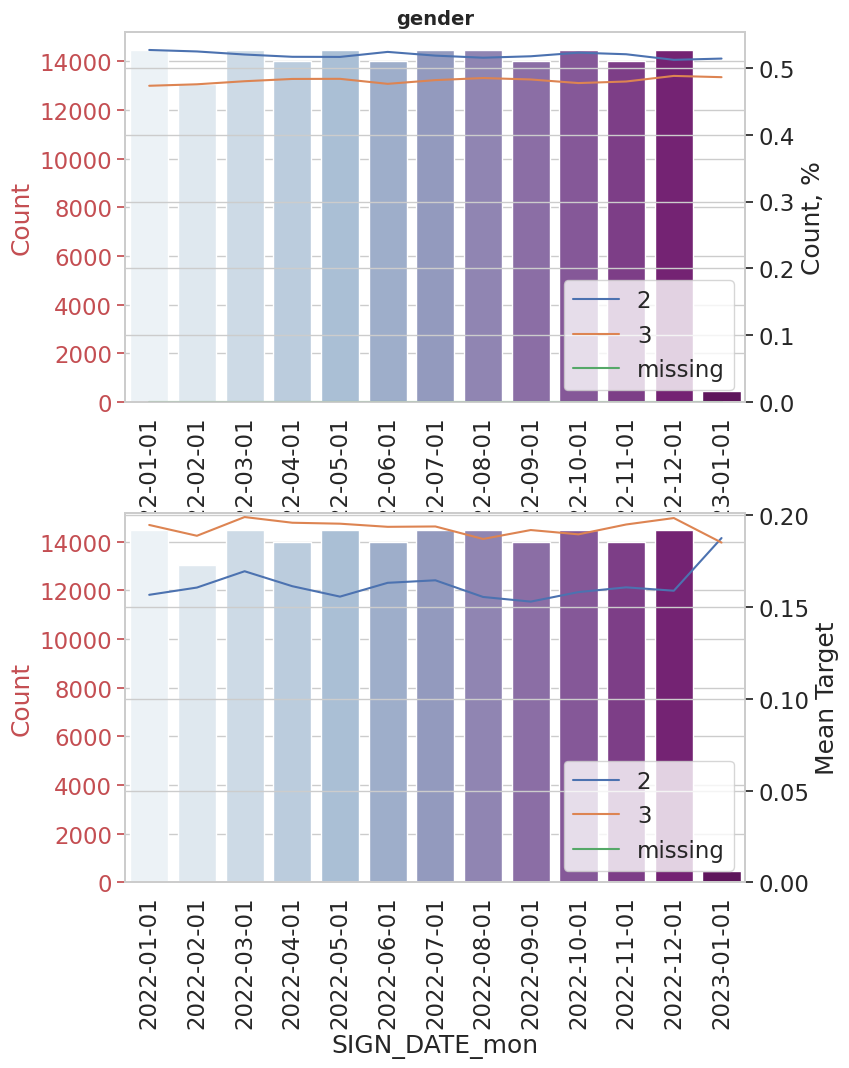

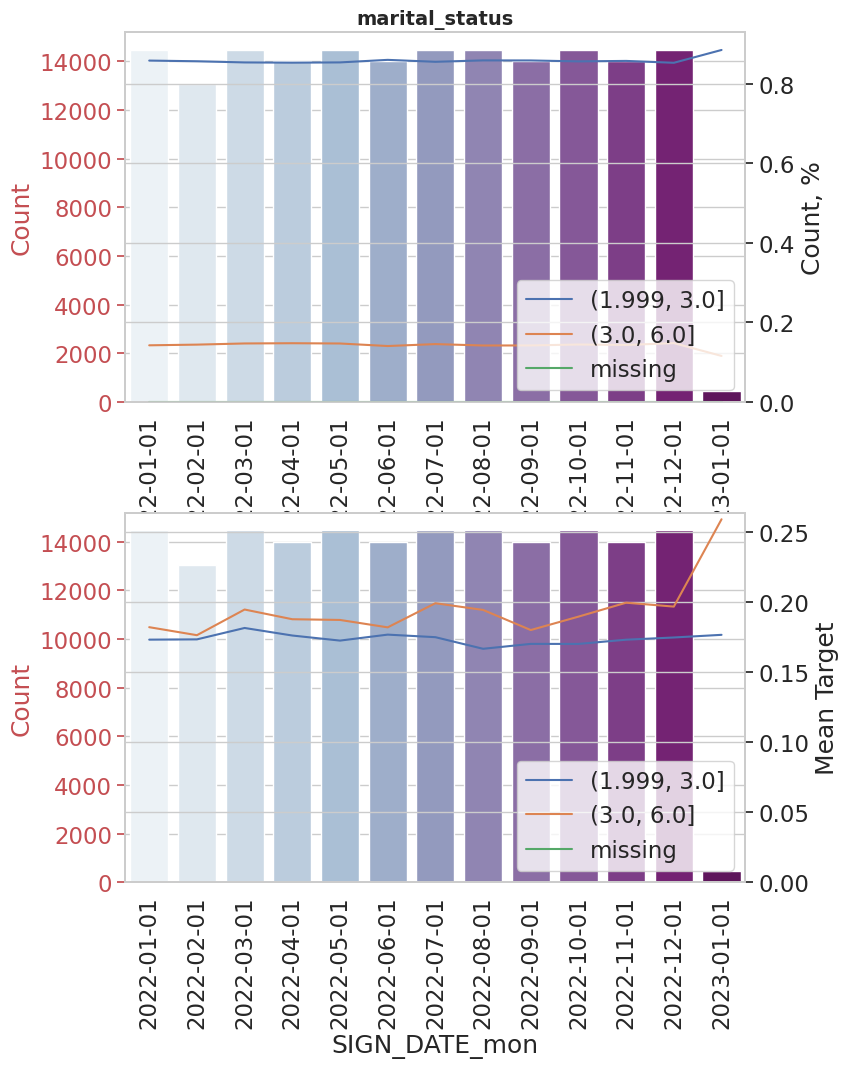

In [ ]:
report_onefactor = onefactor(df, shap_df, col_date=params['col_date_mon'],
          col_target=params['col_target'],
          report_directory='report',
        output_file='README_onefactor_unstable.md',
          top_features=top_features)

#### Predict & Report

In [ ]:
train['predict_boosting'] = model_class.transform(train)
test['predict_boosting'] = model_class.predict(test)
test['predict_test'] = model.predict(test[model.feature_name()])

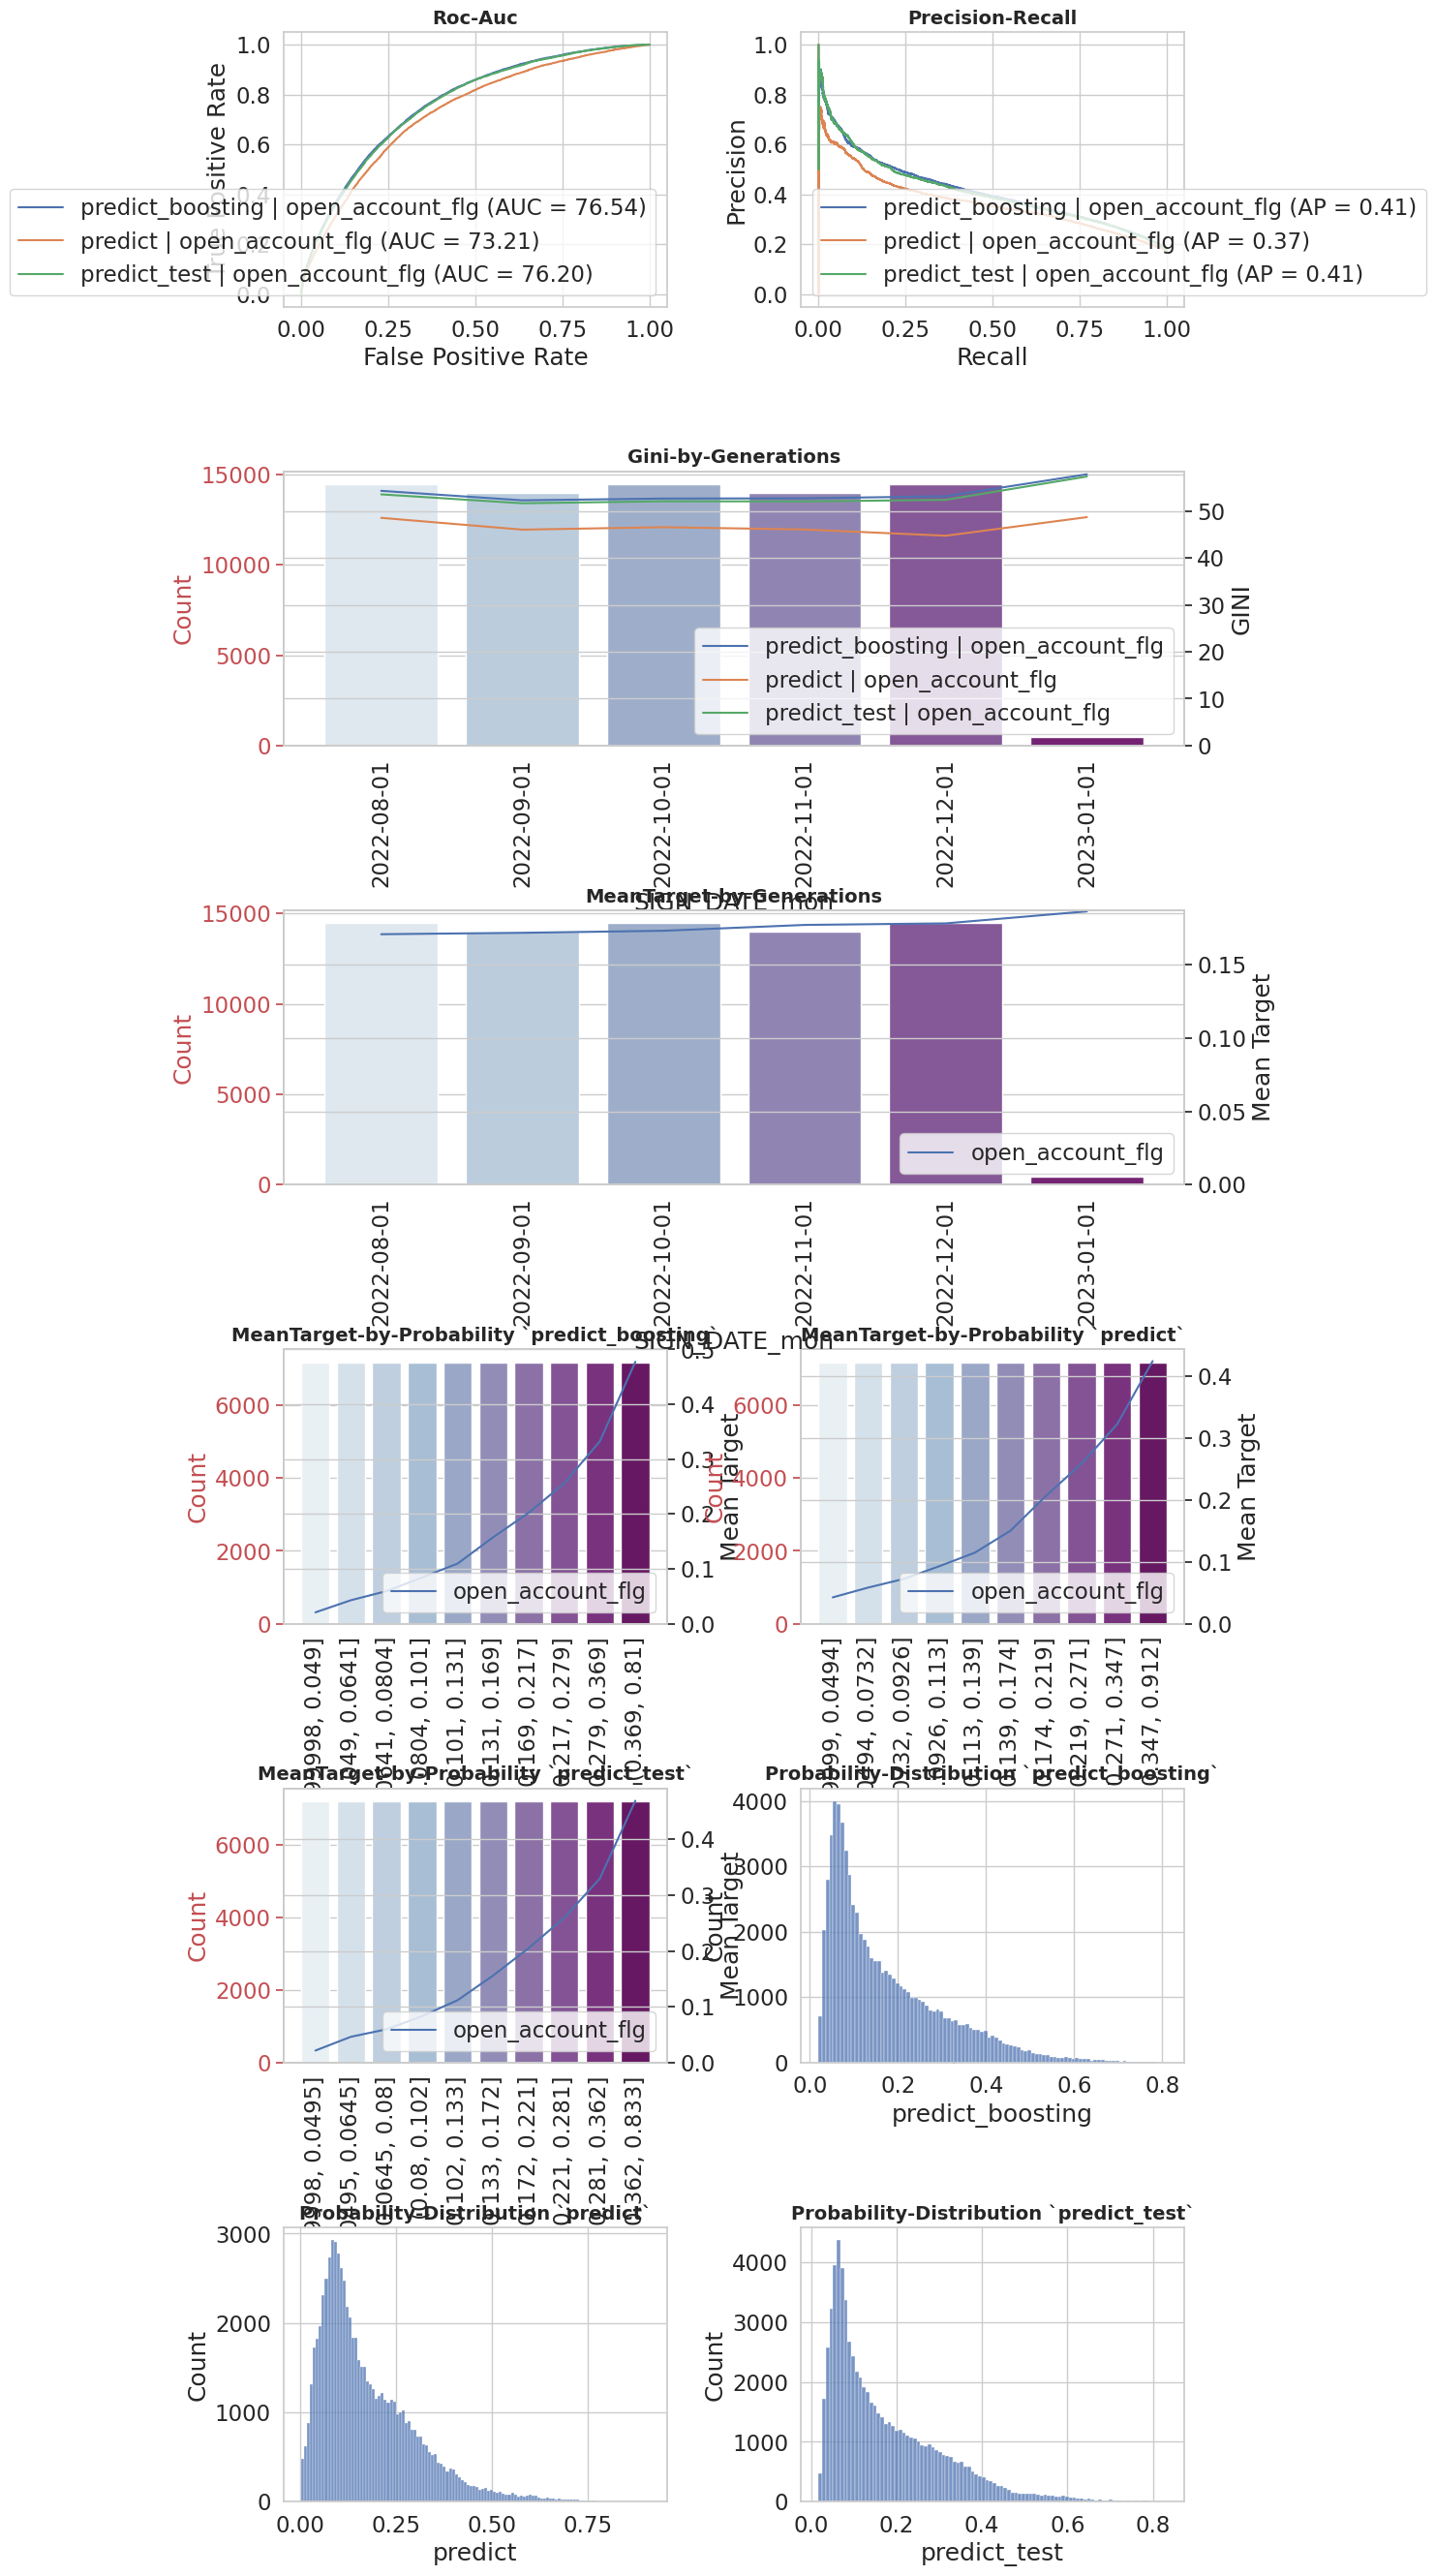

In [ ]:
a = ReportBinary()
a.plot_report(
    test,
    report_shape = (6,2),
    report={'Roc-Auc':  {'loc':(0, 0)},
          'Precision-Recall': [{'loc':(0, 1)}],
          'MeanTarget-by-Probability': [{'loc':(3, 0)},{'loc':(3, 1)},{'loc':(4, 0)}],
          'Gini-by-Generations': {'loc':(1,0), 'colspan':2},
          'MeanTarget-by-Generations': {'loc':(2,0), 'colspan':2},
          'Probability-Distribution': [{'loc':(4,1)},{'loc':(5,0)},{'loc':(5,1)}]},
    cols_score = ['predict_boosting','predict','predict_test'],
    cols_target = [params['col_target']],
    col_generation_deals=params['col_date_mon']
)
# a.fig.savefig('report1.png')

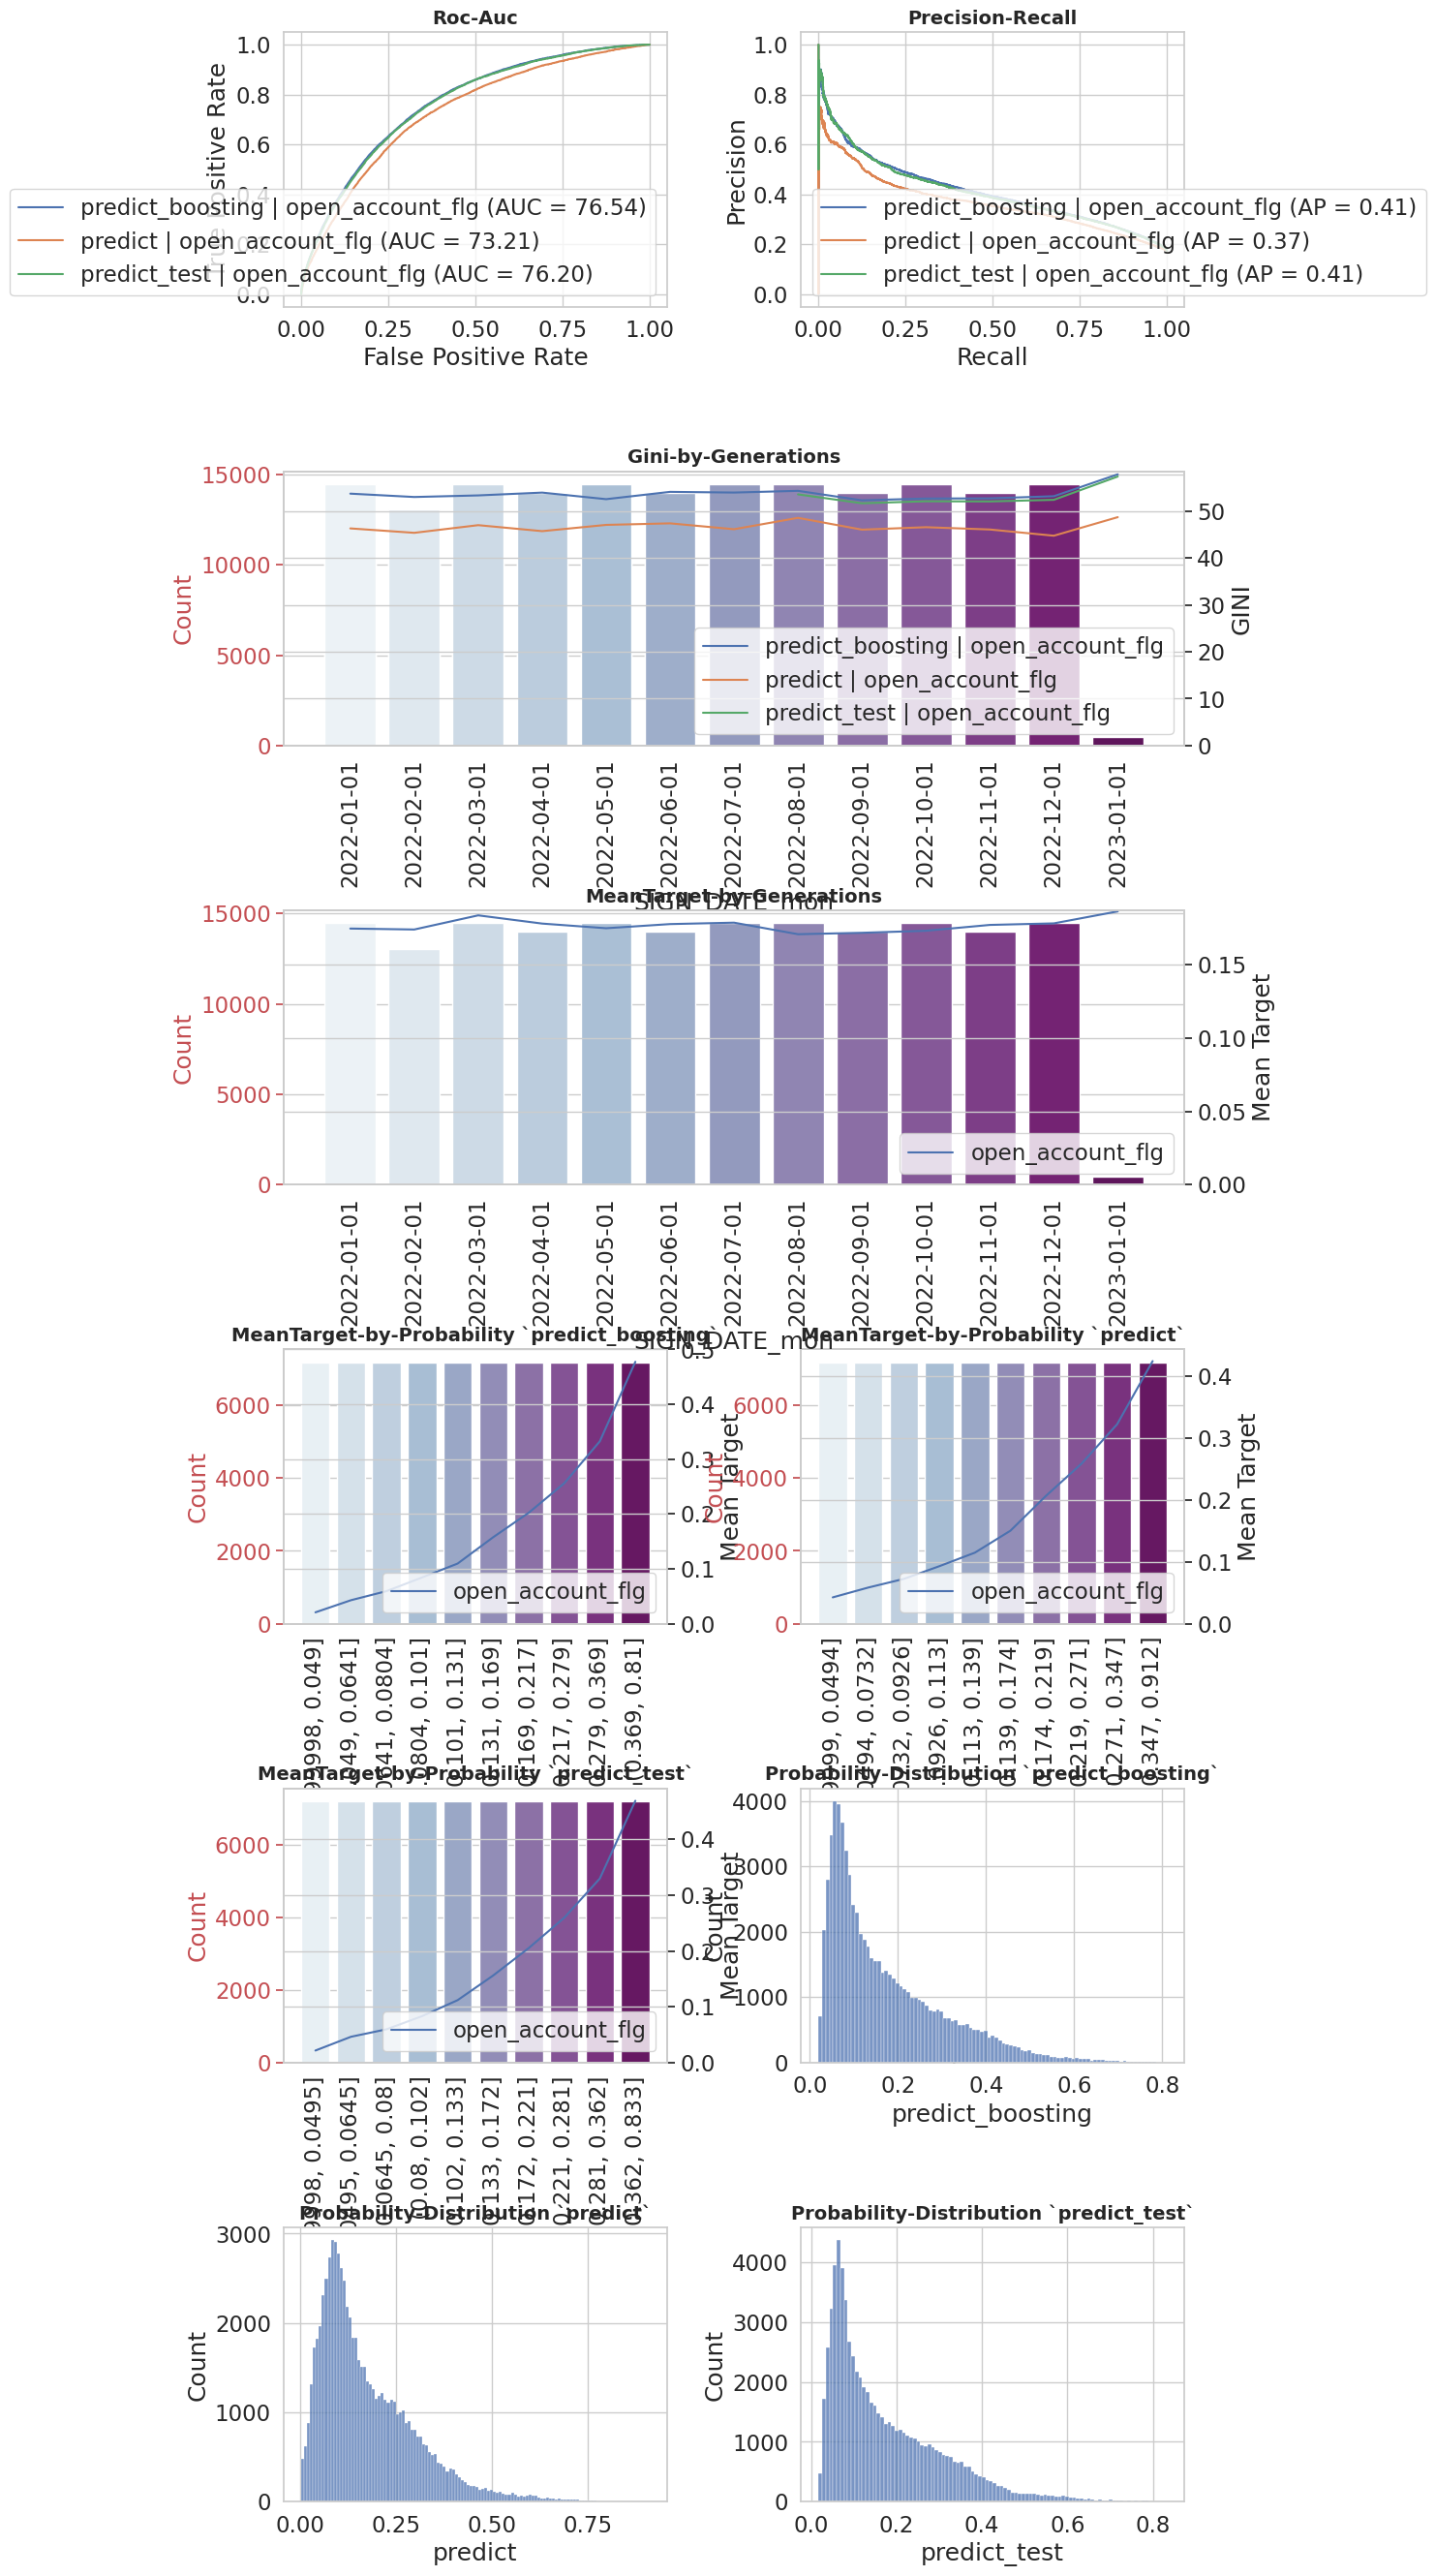

In [ ]:
a = ReportBinary()
a.plot_report(
    pd.concat([train,test],axis=0),
    report_shape = (6,2),
    report={'Roc-Auc':  {'loc':(0, 0)},
          'Precision-Recall': [{'loc':(0, 1)}],
          'MeanTarget-by-Probability': [{'loc':(3, 0)},{'loc':(3, 1)},{'loc':(4, 0)}],
          'Gini-by-Generations': {'loc':(1,0), 'colspan':2},
          'MeanTarget-by-Generations': {'loc':(2,0), 'colspan':2},
          'Probability-Distribution': [{'loc':(4,1)},{'loc':(5,0)},{'loc':(5,1)}]},
    cols_score = ['predict_boosting','predict','predict_test'],
    cols_target = [params['col_target']],
    col_generation_deals=params['col_date_mon']
)
# a.fig.savefig('report1.png')

## 2. GNN для скоринга
## из соревнования с нашего курса по GNN  https://www.kaggle.com/t/968e60cb14394c6f9a0df5b2162f16c5

In [ ]:
!pip install pyarrow -q

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html -q
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html -q
!pip install git+https://github.com/pyg-team/pytorch_geometric.git -q

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 80.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
print(torch.cuda.is_available())
import torch_geometric

True


In [ ]:
import numpy as np
import pandas as pd
import sys
import os
import pandas as pd
import numpy as np
import tqdm
import time
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget -q "https://drive.usercontent.google.com/download?id=171NzARmhcXDtHVSb4aVrGvZr2RUfxEpu&export=download&confirm=t" -O data_original.zip
!unzip -o data_original.zip
!rm data_original.zip

Archive:  data_original.zip
  inflating: test.csv                
  inflating: train.csv               
  inflating: df_edges.parquet        
  inflating: df_nodes.parquet        
  inflating: sample_submission.csv   


In [ ]:
%%time
df_edges = pd.read_parquet('df_edges.parquet')
df_nodes = pd.read_parquet('df_nodes.parquet')

CPU times: user 17.7 s, sys: 5.48 s, total: 23.2 s
Wall time: 14 s


In [ ]:
df_nodes.head(2)

node_feature_1  node_feature_2  node_feature_3  node_feature_4  \
0             0.0             NaN             1.0             NaN   
1             1.0             1.0             1.0             1.0   

   node_feature_5  node_feature_6  node_feature_7  node_feature_8  \
0             1.0             NaN             1.0             NaN   
1             1.0             1.0             1.0             1.0   

   node_feature_9  node_feature_10  ...  node_feature_237  node_feature_238  \
0             NaN              1.0  ...          0.638939          0.891876   
1             1.0              0.0  ...               NaN               NaN   

   node_feature_239  node_feature_240  node_feature_241  node_feature_242  \
0           0.41435               0.0               0.0          0.083106   
1               NaN               NaN               NaN               NaN   

   node_feature_243  node_feature_244  node_feature_245  index  
0               0.0          0.429199          0.394773      0  
1               NaN               NaN               NaN      1  

[2 rows x 246 columns]

In [ ]:
node_group_col = 'node_feature_1'
del df_nodes['index']

In [ ]:
a = df_nodes.isnull()#.sum(axis=0)

b = a[df_nodes[node_group_col]==0].sum(axis=0)
features_group0 = b[b==0].index.tolist()
features_group0.remove(node_group_col)

b = a[df_nodes[node_group_col]==1].sum(axis=0)
features_group1 = b[b==0].index.tolist()
features_group1.remove(node_group_col)

del a

In [ ]:
print("Число фичей для группы вершин 0:",len(features_group0))
print("Число фичей для группы вершин 1:",len(features_group1))

Число фичей для группы вершин 0: 134
Число фичей для группы вершин 1: 162


In [ ]:
# Найдем индексы этих фичей
cols = df_nodes.columns.tolist()
features_idx_group0 = [cols.index(c) for c in features_group0]
features_idx_group1 = [cols.index(c) for c in features_group1]
df_edges.head(2)

edge_feature_1  edge_feature_2  edge_feature_3  edge_feature_5  \
0             0.0             1.0        1.436122        3.165249   
1             0.0             1.0       -0.558463        0.047527   

   edge_feature_7  edge_feature_9  edge_feature_11  edge_feature_12  \
0       -1.992887        2.245767        -1.228802        -0.397216   
1       -0.993277       -0.591337        -1.228802        -0.581673   

   edge_feature_13  edge_feature_14  ...  edge_feature_41  edge_feature_42  \
0        -1.714951         0.829714  ...         1.736383         0.960876   
1        -1.714951         0.829714  ...         0.000000         0.057755   

   edge_feature_43  edge_feature_44  edge_feature_45  edge_feature_46  \
0         0.768179              0.0         2.592106         0.979613   
1         0.000000              0.0         0.000000         0.427619   

   edge_feature_47  edge_feature_48  index1  index2  
0         0.351759              0.0   15000       0  
1         0.351759              0.0   15001       0  

[2 rows x 46 columns]

In [ ]:
x = torch.FloatTensor(df_nodes.values)
edge_index = torch.LongTensor(df_edges[['index1','index2']].values).T

del df_edges['index1']
del df_edges['index2']

edge_attr = torch.FloatTensor(df_edges.values)
from torch_geometric.data import Data

### Таргет

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
# 4 бинарных таргета
# доли 1 в каждом тарегте, число 1, размер выборки по таргету
df_train.groupby('label_type').y.agg(['mean','sum','count'])

mean  sum  count
label_type                      
label_3     0.039683   10    252
label_4     0.033245   63   1895
label_5     0.055487  180   3244
label_6     0.017566   83   4725

In [ ]:
# размер выборки по таргету для test
df_test.label_type.value_counts()

label_6    2327
label_5    1597
label_4     935
label_3     123
Name: label_type, dtype: int64

In [ ]:
df_y = df_train.pivot(columns='label_type',index='index',values='y')
df_y.head()

label_type  label_3  label_4  label_5  label_6
index                                         
4               NaN      NaN      NaN      0.0
7               NaN      NaN      NaN      0.0
8               NaN      NaN      NaN      0.0
10              NaN      NaN      0.0      NaN
11              NaN      NaN      0.0      NaN

In [ ]:
df_y_ = pd.DataFrame(np.arange(len(x)) , columns=['index'])
df_y = df_y_.merge(df_y.reset_index(), on='index',how='left').set_index('index')
df_y.head()

label_3  label_4  label_5  label_6
index                                    
0          NaN      NaN      NaN      NaN
1          NaN      NaN      NaN      NaN
2          NaN      NaN      NaN      NaN
3          NaN      NaN      NaN      NaN
4          NaN      NaN      NaN      0.0

In [ ]:
df_y['has_target'] = df_y.notnull().sum(axis=1) > 0
df_y = df_y.fillna(-100)
df_y.head(1)

label_3  label_4  label_5  label_6  has_target
index                                                
0       -100.0   -100.0   -100.0   -100.0       False

In [ ]:
node_type = torch.ShortTensor(df_nodes[node_group_col].values)

### Data

In [ ]:
# 4 таргета
label_3 = torch.LongTensor(df_y.label_3.values)
label_4 = torch.LongTensor(df_y.label_4.values)
label_5 = torch.LongTensor(df_y.label_5.values)
label_6 = torch.LongTensor(df_y.label_6.values)

#
has_target = torch.BoolTensor(df_y.has_target.values)

In [ ]:
data = Data(x=x, # node features
            edge_index=edge_index, # edges
            edge_attr=edge_attr, # edge attributes
            label_3=label_3,
            label_4=label_4,
            label_5=label_5,
            label_6=label_6,
            has_target=has_target,# whether node has target
            node_type=node_type, # 0 or 1st type of node
            index = torch.arange(len(x))# unique identifier of node
           )

In [ ]:
print('===================================')

print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of edges: {data.edge_index.shape[1]}')
print(f'Number of features: {data.x.shape[1]}')

if data.edge_attr is not None:
    print(f'Number of edge attributes: {data.edge_attr.shape[1]}')


print(f'Number of nodes with target: {int(data.has_target.sum())}')
print('===================================')

Number of nodes: 3356115
Number of edges: 3921554
Number of features: 245
Number of edge attributes: 44
Number of nodes with target: 10050


### Локальная валидация

In [ ]:
from sklearn.model_selection import train_test_split
stratify = df_y[df_y['has_target']].drop('has_target',axis=1).max(axis=1)
train_index, valid_index = train_test_split(torch.nonzero(data.has_target)[:,0],
                                            test_size=0.2,
                                            shuffle=True,
                                            stratify=stratify,
                                            random_state=402)
test_index = df_test['index'].unique()
len(train_index), len(valid_index), len(test_index)

(8040, 2010, 4950)

In [ ]:
from torch_geometric.loader import NeighborLoader
batch_size = 200

loader_train = NeighborLoader(
    data,
    num_neighbors=[-1, -1],
    batch_size=batch_size,
    shuffle=False,
    input_nodes=train_index,
)

loader_valid = NeighborLoader(
    data,
    num_neighbors=[-1, -1],
    batch_size=batch_size,
    shuffle=False,
    input_nodes=valid_index,
)


loader_test = NeighborLoader(
    data,
    num_neighbors=[-1, -1],
    batch_size=batch_size,
    shuffle=False,
    input_nodes=test_index,
)

loader_train = [c for c in tqdm.tqdm(loader_train)]
loader_valid = [c for c in tqdm.tqdm(loader_valid)]
loader_test = [c for c in tqdm.tqdm(loader_test)]

100%|██████████| 25/25 [00:06<00:00,  4.12it/s]


### Модель

In [ ]:
from torch.nn import Linear, ReLU, Sequential, Identity, Dropout, PReLU, Tanh, ELU, LeakyReLU, Sigmoid, GELU
from torch_geometric.nn import GraphConv, SAGEConv

In [ ]:
class GeneralGNN(torch.nn.Module):
    def __init__(self,
                 Act = ReLU,
                 ConvClass = GraphConv,
                 hidden_size1 = 256,
                 conv1_aggrs = {'mean':128, 'max':64, 'add':32},
                 conv2_aggrs = {'mean': 64, 'max':16, 'add':8},
                 dropout_rate = 0.25,
                 target_names = ['label_3','label_4','label_5','label_6'],
                 features_idx_group0 = features_idx_group0,
                 features_idx_group1 = features_idx_group1,
                ):
        super(GeneralGNN, self).__init__()
        torch.manual_seed(420)

        self.hidden_size1 = hidden_size1
        self.target_names = target_names
        self.features_idx_group0 = features_idx_group0
        self.features_idx_group1 = features_idx_group1


        # preprocces node featrues, reduce to a common dimension
        self.lin_preproc = torch.nn.ModuleList(
            modules = [
                Linear(len(features_idx_group0), hidden_size1),
                Linear(len(features_idx_group1), hidden_size1)
            ]
        )
        self.activation = Act()
        self.dropout = Dropout(dropout_rate)


        # 1-level convolution with different aggregate functions
        input_size = hidden_size1

        self.conv1 = torch.nn.ModuleDict()
        for aggr, output_size in conv1_aggrs.items():
            self.conv1[aggr] = ConvClass(input_size, output_size, aggr)

        self.conv1_activation = Act()
        self.conv1_dropout = Dropout(dropout_rate)


        # 2-level convolution with different aggregate functions
        input_size = sum(conv1_aggrs.values())

        self.conv2 = torch.nn.ModuleDict()
        for aggr, output_size in conv2_aggrs.items():
            self.conv2[aggr] = ConvClass(input_size, output_size, aggr)

        self.conv2_activation = Act()
        self.conv2_dropout = Dropout(dropout_rate)
        # MAKE PREDICTION FOR EACH TASK
        input_size = sum(conv2_aggrs.values())
        self.lin_out = torch.nn.ModuleDict()
        for name in self.target_names:
            self.lin_out[name] = Linear(input_size, 2)


    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        node_type = data.node_type

        # preprocces node featrues, reduce to a common dimension
        x_out = torch.zeros(len(x), self.hidden_size1, device=x.device)

        x_out[node_type==0] = self.lin_preproc[0](x[node_type==0][:,self.features_idx_group0])
        x_out[node_type==1] = self.lin_preproc[1](x[node_type==1][:,self.features_idx_group1])

        x = self.dropout(self.activation(x_out))

        # concatencate outputs of 1-level convolution with different aggregate functions
        x_out = []
        for conv in self.conv1.values():
            x_out.append(conv(x, edge_index))
        x = torch.cat(x_out, dim=1)
        x = self.conv1_dropout(self.conv1_activation(x))

        # concatencate outputs of 2-level convolution with different aggregate functions
        x_out = []
        for conv in self.conv2.values():
            x_out.append(conv(x, edge_index))
        x = torch.cat(x_out, dim=1)
        x = self.conv2_dropout(self.conv2_activation(x))

        outs = {name: self.lin_out[name](x) for name in self.target_names}

        return outs

In [ ]:
model = GeneralGNN()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

GeneralGNN(
  (lin_preproc): ModuleList(
    (0): Linear(in_features=134, out_features=256, bias=True)
    (1): Linear(in_features=162, out_features=256, bias=True)
  )
  (activation): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (conv1): ModuleDict(
    (mean): GraphConv(256, 128)
    (max): GraphConv(256, 64)
    (add): GraphConv(256, 32)
  )
  (conv1_activation): ReLU()
  (conv1_dropout): Dropout(p=0.25, inplace=False)
  (conv2): ModuleDict(
    (mean): GraphConv(224, 64)
    (max): GraphConv(224, 16)
    (add): GraphConv(224, 8)
  )
  (conv2_activation): ReLU()
  (conv2_dropout): Dropout(p=0.25, inplace=False)
  (lin_out): ModuleDict(
    (label_3): Linear(in_features=88, out_features=2, bias=True)
    (label_4): Linear(in_features=88, out_features=2, bias=True)
    (label_5): Linear(in_features=88, out_features=2, bias=True)
    (label_6): Linear(in_features=88, out_features=2, bias=True)
  )
)

In [ ]:
def train_epoch(model, loader, device, optimizer, scheduler, tqdm_disable=True):
    """
    учим модель одну эпоху
    """
    start_time = time.time()

    model.train()
    total_loss = 0

    for sampled_data in tqdm.tqdm(loader, leave=False, disable=tqdm_disable):
        sampled_data = sampled_data.clone().to(device)
        sampled_data.has_target[sampled_data.batch_size:] = False

        optimizer.zero_grad()
        outs = model(sampled_data)
        loss = get_train_loss(sampled_data, outs)
#         loss = F.nll_loss(out[sampled_data.label_mask], sampled_data.y[sampled_data.label_mask])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        total_loss += loss.detach().item() / len(loader)

    scheduler.step()

    calc_time = time.time() - start_time
    return total_loss, calc_time

In [ ]:
def get_train_loss(sampled_data, outs):
    ys = {name: getattr(sampled_data,name)[:sampled_data.batch_size] for name in target_names}
    outs = {name: outs[name][:sampled_data.batch_size] for name in target_names}
    loss = 0
    for name in target_names:
        y = ys[name]
        out = outs[name]
        l = criterion(out,y)
        if not torch.isnan(l):
            loss +=l
    return loss/batch_size

In [ ]:
def eval_model(model, loader, device, tqdm_disable=True):
    """
    get prediction


    """
    start_time = time.time()
    softmax = torch.nn.Softmax(dim=1)

    dfs = []

    model.eval()
    with torch.no_grad():

        for sampled_data in tqdm.tqdm(loader, leave=False, disable=tqdm_disable):
            sampled_data = sampled_data.clone().to(device)
            outs = model(sampled_data)
            outs = {name: softmax(
                                outs[name][:sampled_data.batch_size].detach()
                            )[:,1].cpu().numpy() for name in target_names
                   }
            outs['index'] = sampled_data.index[:sampled_data.batch_size].cpu().numpy()
            dfs.append(pd.DataFrame(outs))

    result = pd.concat(dfs,axis=0)

    df_score = pd.melt(result, id_vars=['index'], value_vars=target_names).rename(
    columns={'variable':'label_type','value':'score'})
    return df_score

In [ ]:
from sklearn.metrics import roc_auc_score
def cacl_auc(df_score, df_truth):
    df = df_truth.merge(df_score, on=['index','label_type'])
    return roc_auc_score(df.y, df.score) #, df.shape[0]

In [ ]:
target_names = ['label_3','label_4','label_5','label_6']

In [ ]:
# там где таргет -100 лосс не считаем
criterion = torch.nn.CrossEntropyLoss(reduction='sum', ignore_index=-100, label_smoothing = 0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
      optimizer = optimizer,
      milestones = [10, 20, 40],
      gamma = 0.1)

### Train

In [ ]:
for epoch in range(10):
    total_loss, calc_time = train_epoch(model, loader_train, device, optimizer, scheduler, tqdm_disable=False)

    df_score = eval_model(model, loader_train, device, tqdm_disable=True)
    train_auc = cacl_auc(df_score, df_train)

    df_score = eval_model(model, loader_valid, device, tqdm_disable=True)
    valid_auc = cacl_auc(df_score, df_train)

    print(f'Epcoh:{epoch:03d} TrainLoss : {total_loss:.3f}, Train AUC : {train_auc:.3f}, VALID AUC : {valid_auc:.3f}',
          file=sys.stderr)

Epcoh:000 TrainLoss : 0.393, Train AUC : 0.740, VALID AUC : 0.684
Epcoh:001 TrainLoss : 0.148, Train AUC : 0.764, VALID AUC : 0.675
Epcoh:002 TrainLoss : 0.143, Train AUC : 0.779, VALID AUC : 0.677
Epcoh:003 TrainLoss : 0.139, Train AUC : 0.781, VALID AUC : 0.662
Epcoh:004 TrainLoss : 0.137, Train AUC : 0.826, VALID AUC : 0.703
Epcoh:005 TrainLoss : 0.135, Train AUC : 0.826, VALID AUC : 0.692
Epcoh:006 TrainLoss : 0.133, Train AUC : 0.785, VALID AUC : 0.637
Epcoh:007 TrainLoss : 0.134, Train AUC : 0.824, VALID AUC : 0.692
Epcoh:008 TrainLoss : 0.134, Train AUC : 0.798, VALID AUC : 0.652
Epcoh:009 TrainLoss : 0.134, Train AUC : 0.831, VALID AUC : 0.695


In [ ]:
# df_score = eval_model(model, loader_test, device, tqdm_disable=True)
# df_submission = df_score.merge(df_test, on=['index','label_type'])
# df_submission[['task_id','score']].to_csv('submission.csv',index=False, header=True)